# Предсказание температуры стали

Для оптимизации производственных расходов металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

Технологический процесс выглядит следующим образом:
1. Расплавленную сталь заливают в ковш и нагревают до нужной температуры графитовыми электродами.
2. Производят десульфурацию.
3. Производят замер температуры и химический анализ стали.
4. Повышают температуру на несколько минут и вводят легирующие добавки (сыпучие или проволочные материалы).
5. Продувают сплав инертным газом.
6. Перемешивают сплав, снова производят замер температуры и химический анализ стали.
7. При необходимости повторяют пп. 3...6 до достижения целевого химического состава и оптимальной температуры плавки.
8. Сталь поступает в машину непрерывной разливки, откуда выходит готовый продукт в виде заготовок-слябов.

Заказчик настаивает на том, что все полученные данные реальные и хотел бы получить модель, обученную на максимально полном объёме данных. При этом в данных могут быть нестыковки по времени выполнения операций - это особенности получения и записи информации с датчиков.

**План работы**

1. Исследовательский анализ данных.


2. Предобработка данных:
- агрегация данных по ключам и создание новых признаков;
- работа с пропусками;
- создание сводной таблицы.
3. Обучение моделей и выбор лучшей:
- простые модели;
- модель градиентного бустинга;
- константная модель для проверки адекватности.
4. Проверка качества модели на тестовой выборке.

## 1 Исследовательский анализ данных

Импортируем все необходимые для работы библиотеки, откроем файлы с данными и изучим общую информацию о них.

In [1]:
# импорт библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# импорт структур, модулей, функций
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# установка максимального количества отображаемых столбцов
pd.options.display.max_columns = 50

# константа, фиксирующая случайность
rs = 250722

### 1.1 Данные об электродах

In [3]:
# чтение файла с данными об электродах
data_arc = pd.read_csv('/final_steel/data_arc.csv')
    
# просмотр первых пяти строк полученной таблицы
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
# получение общей информации о данных
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В таблице 14876 записей, 5 признаков:
- `key` - номер партии;
- `начало нагрева дугой`;
- `конец нагрева дугой`;
- `активная мощность`;
- `реактивная мощность`.

Пропусков в признаках нет, типы данных соответствуют по смыслу признакам, кроме признаков начала и конца нагрева, которые следует привести к типу даты и времени.

Названия признаков следует дать латиницей в змеином регистре.

In [5]:
# переименование признаков
data_arc = data_arc.rename(columns={'Начало нагрева дугой':'arc_heat_start',
                                    'Конец нагрева дугой':'arc_heat_end',
                                    'Активная мощность':'act_power',
                                    'Реактивная мощность':'react_power'}
                          )
# просмотр названий признаков
data_arc.columns

Index(['key', 'arc_heat_start', 'arc_heat_end', 'act_power', 'react_power'], dtype='object')

Признаки переименованы.

Заменим тип данных признаков `arc_heat_start` и `arc_heat_end` на `datetime64[ns]`:

In [6]:
data_arc[['arc_heat_start',
          'arc_heat_end']] = data_arc[['arc_heat_start',
                                       'arc_heat_end']].apply(pd.to_datetime)
data_arc.dtypes

key                        int64
arc_heat_start    datetime64[ns]
arc_heat_end      datetime64[ns]
act_power                float64
react_power              float64
dtype: object

Типы данных заменены.

In [7]:
# получение характерных значений количественных признаков
data_arc.describe()

,key,act_power,react_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В таблице присутствуют данные о ключах 1...3241. Посмотрим, сколько их всего:

In [8]:
data_arc['key'].nunique()

3214

Всего в данной таблице 3214 ключей, т.е. номера партий идут не по порядку, есть пропуски в нумерации.

Минимальное значение активной мощности - 0.03 у.е., среднее - 0.67 у.е., максимальное - 3.73 у.е. Явных ошибок пока не видно.

Минимальное значение реактивной мощности составляет -715 у.е., среднее - 0.45 у.е., максимальное - 2.68 у.е. Значение мощности не может быть отрицательным, следовательно, минимальная величина - это выброс, надо посмотреть, много ли отрицательных значений этого признака, и решить, что с ними делать.

In [9]:
# получение среза данных с реактивной мощностью меньше 0
data_arc.query('react_power < 0')

,key,arc_heat_start,arc_heat_end,act_power,react_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Только у одного ключа значение реактивной мощности отрицательное, удалим его из данных:

In [10]:
print(data_arc.shape)
data_arc = data_arc.query('key != 2116')
data_arc.shape

(14876, 5)


(14872, 5)

Ключ с отрицательным значением реактивной мощности удалён.

Проверим, в каких временных диапазонах происходил нагрев дугой:

In [11]:
print('Минимальное время начала нагрева:', data_arc['arc_heat_start'].min())
print('Минимальное время конца нагрева:', data_arc['arc_heat_end'].min())
print('Максимальное время начала нагрева:', data_arc['arc_heat_start'].max())
print('Максимальное время конца нагрева:', data_arc['arc_heat_end'].max())

Минимальное время начала нагрева: 2019-05-03 11:02:14
Минимальное время конца нагрева: 2019-05-03 11:06:02
Максимальное время начала нагрева: 2019-09-01 04:34:47
Максимальное время конца нагрева: 2019-09-01 04:36:08


Данные о нагреве представлены за период с 11:02:14 3 мая по 04:36:08 1 сентября 2019 года.

### 1.2 Данные об объёме подачи сыпучих материалов

In [12]:
# чтение файла с данными об объёме подачи сыпучих материалов
data_bulk = pd.read_csv('/final_steel/data_bulk.csv')

# просмотр первых пяти строк полученной таблицы
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
# получение общей информации о данных
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В таблице 3129 записей, 16 признаков:
- `key` - номер партии;
- `Bulk 1` ... `Bulk 15` - объёмы подачи сыпучих материалов 1...15.

В данных об объёмах подачи сыпучих материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями.

Типы данных соответствуют по смыслу признакам.

Названия признаков следует дать в змеином регистре.

In [14]:
# переименование признаков
data_bulk = data_bulk.rename(columns={'Bulk 1':'bulk_1',
                                      'Bulk 2':'bulk_2',
                                      'Bulk 3':'bulk_3',
                                      'Bulk 4':'bulk_4',
                                      'Bulk 5':'bulk_5',
                                      'Bulk 6':'bulk_6',
                                      'Bulk 7':'bulk_7',
                                      'Bulk 8':'bulk_8',
                                      'Bulk 9':'bulk_9',
                                      'Bulk 10':'bulk_10',
                                      'Bulk 11':'bulk_11',
                                      'Bulk 12':'bulk_12',
                                      'Bulk 13':'bulk_13',
                                      'Bulk 14':'bulk_14',
                                      'Bulk 15':'bulk_15'}
                          )
# просмотр названий признаков
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Признаки переименованы.

In [15]:
# получение характерных значений количественных признаков
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В таблице присутствуют данные о 3129 ключах, т.е. представлены не все ключи (всего их 3214).

Явных ошибок в объёмах сыпучих материалов не выявлено.

### 1.3 Данные о времени подачи сыпучих материалов

In [16]:
# чтение файла с данными о времени подачи сыпучих материалов
data_bulk_time = pd.read_csv('/final_steel/data_bulk_time.csv')

# просмотр первых пяти строк полученной таблицы
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [17]:
# получение общей информации о данных
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


В таблице 3129 записей, 16 признаков:
- `key` - номер партии;
- `Bulk 1` ... `Bulk 15` - время подачи сыпучих материалов 1...15.

В данных о времени подачи сыпучих материалов также присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски можно заполнить нулями, однако, данная таблица в дальнейшем не будет использована, поэтому заполнение не требуется. По этой же причине названия признаков к змеиному регистру приводить не будем.

Приведём лишь данные о времени к типу даты и времени, чтобы убедиться, что временные диапазоны соответствуют остальным таблицам.

In [18]:
data_bulk_time[['Bulk 1', 'Bulk 2',
                'Bulk 3', 'Bulk 4',
                'Bulk 5', 'Bulk 6',
                'Bulk 7', 'Bulk 8',
                'Bulk 9', 'Bulk 10',
                'Bulk 11', 'Bulk 12',
                'Bulk 13', 'Bulk 14',
                'Bulk 15']] = data_bulk_time[['Bulk 1', 'Bulk 2',
                                              'Bulk 3', 'Bulk 4',
                                              'Bulk 5', 'Bulk 6',
                                              'Bulk 7', 'Bulk 8',
                                              'Bulk 9', 'Bulk 10',
                                              'Bulk 11', 'Bulk 12',
                                              'Bulk 13', 'Bulk 14',
                                              'Bulk 15']].apply(pd.to_datetime)
data_bulk_time.dtypes

key                 int64
Bulk 1     datetime64[ns]
Bulk 2     datetime64[ns]
Bulk 3     datetime64[ns]
Bulk 4     datetime64[ns]
Bulk 5     datetime64[ns]
Bulk 6     datetime64[ns]
Bulk 7     datetime64[ns]
Bulk 8     datetime64[ns]
Bulk 9     datetime64[ns]
Bulk 10    datetime64[ns]
Bulk 11    datetime64[ns]
Bulk 12    datetime64[ns]
Bulk 13    datetime64[ns]
Bulk 14    datetime64[ns]
Bulk 15    datetime64[ns]
dtype: object

Тип данных изменён. Посмотрим на минимальное и максимальное время подачи сыпучих материалов.

In [19]:
# просмотр минимального значения времени
data_bulk_time[['Bulk 1', 'Bulk 2', 'Bulk 3',
                'Bulk 4', 'Bulk 5', 'Bulk 6',
                'Bulk 7', 'Bulk 8', 'Bulk 9',
                'Bulk 10', 'Bulk 11', 'Bulk 12',
                'Bulk 13', 'Bulk 14', 'Bulk 15']].min().min()

Timestamp('2019-05-03 11:03:52')

In [20]:
# просмотр максимального значения времени
data_bulk_time[['Bulk 1', 'Bulk 2', 'Bulk 3',
                'Bulk 4', 'Bulk 5', 'Bulk 6',
                'Bulk 7', 'Bulk 8', 'Bulk 9',
                'Bulk 10', 'Bulk 11', 'Bulk 12',
                'Bulk 13', 'Bulk 14', 'Bulk 15']].max().max()

Timestamp('2019-09-01 04:05:34')

Данные о времени подачи сыпучих материалов представлены за период с 11:03:52 3 мая по 04:05:34 1 сентября 2019 года, что согласуется со временем нагрева.

### 1.4 Данные о продувке сплава газом

In [21]:
# чтение файла с данными о продувке сплава газом
data_gas = pd.read_csv('/final_steel/data_gas.csv')
    
# просмотр первых пяти строк полученной таблицы
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [22]:
# получение общей информации о данных
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В таблице 3239 записей, 2 признака:
- `key` - номер партии;
- `Газ 1` - объём газа.

Пропусков в признаках нет, типы данных соответствуют по смыслу признакам.

Название признака следует дать латиницей в змеином регистре.

In [23]:
# переименование признаков
data_gas = data_gas.rename(columns={'Газ 1':'gas_1'})
# просмотр названий признаков
data_gas.columns

Index(['key', 'gas_1'], dtype='object')

In [24]:
# получение характерных значений количественных признаков
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


В таблице присутствуют данные о 3239 ключах, т.е. имеются данные по ключам, отсутствующим в данных об электродах (там ключей 3213). Проверим, что все ключи уникальные.

In [25]:
data_gas['key'].nunique()

3239

Количество уникальных ключей совпадает с количеством записей, ключи не повторяются. 

Минимальное значение объёма газа - 0.008 у.е., среднее - 11 у.е., максимальное - 78 у.е. Явных ошибок нет.

### 1.5 Результаты измерения температуры

In [26]:
# чтение файла с результатами измерения температуры
data_temp = pd.read_csv('/final_steel/data_temp.csv')
    
# просмотр первых пяти строк полученной таблицы
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [27]:
# получение общей информации о данных
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


В таблице 15907 записей, 3 признака:
- `key` - номер партии;
- `время замера`;
- `температура`.

Присутствуют пропуски в температуре, проанализируем их позже. Типы данных соответствуют по смыслу признакам, кроме времени замера, который следует привести к типу даты и времени.

Названия признаков следует дать латиницей в змеином регистре.

In [28]:
# переименование признаков
data_temp = data_temp.rename(columns={'Время замера':'time_temp',
                                      'Температура':'temp'})
# просмотр названий признаков
data_temp.columns

Index(['key', 'time_temp', 'temp'], dtype='object')

Признаки переименованы.

Приведём время замера к типу даты и времени.

In [29]:
data_temp['time_temp'] = pd.to_datetime(data_temp['time_temp'], format='%Y-%m-%dT%H:%M:%S')
data_temp.dtypes

key                   int64
time_temp    datetime64[ns]
temp                float64
dtype: object

Тип данных заменён. Посмотрим, в каком временном диапазоне производились замеры температуры:

In [30]:
print('Минимальное время замера:', data_temp['time_temp'].min())
print('Максимальное время замера:', data_temp['time_temp'].max())

Минимальное время замера: 2019-05-03 11:16:18
Максимальное время замера: 2019-09-01 04:38:08


Данные о времени замера температуры представлены за период с 11:16:18 3 мая по 04:38:08 1 сентября 2019 года, что согласуется со временем нагрева.

In [31]:
# получение характерных значений количественных признаков
data_temp.describe()

,key,temp
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


В таблице присутствуют данные о ключах 1...3241.

Минимальное значение температуры - 1191 градус, среднее - 1591 градус, максимальное - 1705 градус. Стандартное отклонение всего 21 градус, значит, минимальные и максимальные температуры довольно не типичны. Изучим распределение этого признака.

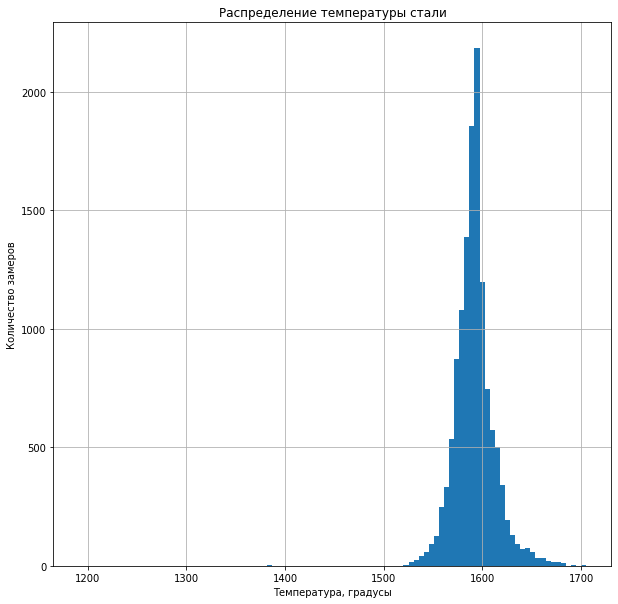

In [32]:
data_temp['temp'].hist(bins=100, figsize=(10,10))
plt.xlabel('Температура, градусы')
plt.ylabel('Количество замеров')
plt.title('Распределение температуры стали')
plt.show()

По гистограмме видно, что распределение температуры близко к нормальному и что практически все значения температуры лежат в диапазоне от 1500 до 1700 градусов. Посмотрим по диаграмме размаха на редкие значения.

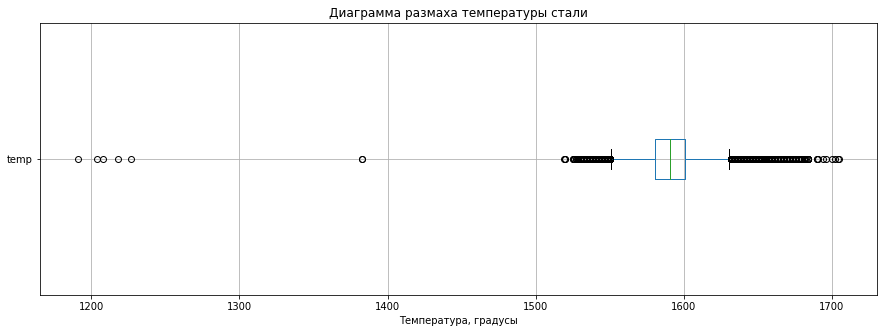

In [33]:
data_temp.boxplot(column='temp', figsize=(15, 5), vert=0)
plt.xlabel('Температура, градусы')
plt.title('Диаграмма размаха температуры стали')
plt.show()

На диаграмме размаха хорошо видно, что значения ниже 1500 градусов единичны, сильно разбросаны и далеко выходят за пределы усов. Значений выше 1700 градусов несколько больше, и они находятся близко друг к другу. Следует уточнить у заказчика, уместно ли удалить ключи с температурами ниже 1500 градусов.

Посмотрим на ключи записей, содержащих пропуски в температуре:

In [34]:
data_temp[data_temp['temp'].isna()].groupby('key')['key'].count()

key
2500    3
2501    4
2502    6
2503    3
2504    2
       ..
3237    4
3238    2
3239    7
3240    7
3241    4
Name: key, Length: 739, dtype: int64

Пропуски в температуре содержатся в ключах, начиная с 2500 и до конца. Восстановить значения не получится, т.к. у нас нет данных о партиях. Значит, эти ключи придётся исключить из дальнейшей работы.

### 1.6 Данные об объёме проволочных материалов

In [35]:
# чтение файла с данными об объёме проволочных материалов
data_wire = pd.read_csv('/final_steel/data_wire.csv')
    
# просмотр первых пяти строк полученной таблицы
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# получение общей информации о данных
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В таблице 3081 запись, 10 признаков:
- `key` - номер партии;
- `Wire 1` ... `Wire 9` - объёмы подачи проволочных материалов 1...9.

В данных об объёмах подачи проволочных материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями.

Типы данных соответствуют по смыслу признакам.

Названия признаков следует дать в змеином регистре.

In [37]:
# переименование признаков
data_wire = data_wire.rename(columns={'Wire 1':'wire_1',
                                      'Wire 2':'wire_2',
                                      'Wire 3':'wire_3',
                                      'Wire 4':'wire_4',
                                      'Wire 5':'wire_5',
                                      'Wire 6':'wire_6',
                                      'Wire 7':'wire_7',
                                      'Wire 8':'wire_8',
                                      'Wire 9':'wire_9'}
                            )
# просмотр названий признаков
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Признаки переименованы.

In [38]:
# получение характерных значений количественных признаков
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


В таблице присутствуют данные о 3081 ключе, т.е. представлены не все ключи (всего их 3214).

Явных ошибок в объёмах проволочных материалов не выявлено.

### 1.7 Данные о времени подачи проволочных материалов

In [39]:
# чтение файла с данными о времени подачи проволочных материалов
data_wire_time = pd.read_csv('/final_steel/data_wire_time.csv')
    
# просмотр первых пяти строк полученной таблицы
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# получение общей информации о данных
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


В таблице 3081 запись, 10 признаков:
- `key` - номер партии;
- `Wire 1` ... `Wire 9` - время подачи проволочных материалов 1...9.

В данных о времени подачи проволочных материалов также присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски можно заполнить нулями, однако, данная таблица в дальнейшем не будет использована, поэтому заполнение не требуется. По этой же причине названия признаков к змеиному регистру приводить не будем.

Приведём лишь данные о времени к типу даты и времени, чтобы убедиться, что временные диапазоны соответствуют остальным таблицам.

In [41]:
data_wire_time[['Wire 1', 'Wire 2',
                'Wire 3', 'Wire 4',
                'Wire 5', 'Wire 6',
                'Wire 7', 'Wire 8',
                'Wire 9']] = data_wire_time[['Wire 1', 'Wire 2',
                                             'Wire 3', 'Wire 4',
                                             'Wire 5', 'Wire 6',
                                             'Wire 7', 'Wire 8',
                                             'Wire 9']].apply(pd.to_datetime)
data_wire_time.dtypes

key                int64
Wire 1    datetime64[ns]
Wire 2    datetime64[ns]
Wire 3    datetime64[ns]
Wire 4    datetime64[ns]
Wire 5    datetime64[ns]
Wire 6    datetime64[ns]
Wire 7    datetime64[ns]
Wire 8    datetime64[ns]
Wire 9    datetime64[ns]
dtype: object

Тип данных изменён. Посмотрим на минимальное и максимальное время подачи сыпучих материалов.

In [42]:
# просмотр минимального значения времени
data_wire_time[['Wire 1', 'Wire 2', 'Wire 3',
                'Wire 4', 'Wire 5', 'Wire 6',
                'Wire 7', 'Wire 8', 'Wire 9']].min().min()

Timestamp('2019-05-03 11:11:41')

In [43]:
# просмотр максимального значения времени
data_wire_time[['Wire 1', 'Wire 2', 'Wire 3',
                'Wire 4', 'Wire 5', 'Wire 6',
                'Wire 7', 'Wire 8', 'Wire 9']].max().max()

Timestamp('2019-09-01 04:16:01')

Данные о времени подачи проволочных материалов представлены за период с 11:11:41 3 мая по 04:16:01 1 сентября 2019 года, что согласуется со временем нагрева и подачи сыпучих материалов.

### 1.8 Вывод

1. Для анализа представлены 7 таблиц с данными, описывающими технологический процесс обработки стали.

<b>Данные об электродах содержат информацию о:</b>
- номере партии,
- времени начала и конца прогрева дугой,
- активной и реактивной мощности.

В таблице 14876 записей, при этом партий (ключей) 3214: из-за того, что обработка партии происходит в несколько итераций, на каждый ключ приходится по несколько записей. Данные по ключам необходимо будет агрегировать. 

Пропусков и явных ошибок нет, кроме одного отрицательного значения реактивной мощности. Ключ, содержащий это значение, удалён.

<b>Данные об объёме подачи сыпучих материалов содержат информацию о:</b>
- номере партии,
- объёме добавленного сыпучего материала 1...15.

В таблице 3129 записей, т.е. записи о некоторых ключах отсутствуют.

В данных об объёмах подачи сыпучих материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями. Явных ошибок нет.

<b>Данные о времени подачи сыпучих материалов содержат информацию о:</b>
- номере партии,
- времени добавления сыпучего материала 1...15.

В таблице, также как и в предыдущей, 3129 записей, т.е. записи о некоторых ключах отсутствуют.

Также присутствуют пропуски; их количество по каждому сыпучему материалу совпадает с количеством пропусков предыдущей таблицы: если материал не добавляли, то и время его добавления отсутствует. Данная таблица в дальнейшем не понадобится, пропуски заполнять не нужно.

<b>Данные о продувке сплава газом содержат информацию о:</b>
- номере партии,
- объёме поданного газа.

В таблице 3239 записей, имеются данные по ключам, отсутствующим в данных об электродах (там ключей 3213).

Пропусков и явных ошибок нет.

<b>Результаты измерения температуры содержат информацию о:</b>
- номере партии,
- времени замера,
- температуре.

В таблице 15907 записей, на каждый ключ приходится по несколько записей. Для исследования представляют интерес начальная и конечная температура стали, являющаяся целевым признаком.

В данных имеются пропуски значений температуры. Они содержатся в ключах, начиная с 2500 и до конца. Восстановить значения не получится, т.к. у нас нет данных о химическом составе ключей, на основе которых можно было бы попытаться восстановить температуру. Значит, эти ключи придётся исключить из дальнейшей работы.

Распределение температуры близко к нормальному и практически все значения температуры лежат в диапазоне от 1500 до 1700 градусов. При этом значения ниже 1500 градусов единичны, сильно разбросаны и далеко выходят за пределы усов. Значений выше 1700 градусов несколько больше, и они находятся близко друг к другу. Следует уточнить у заказчика, уместно ли удалить ключи с температурами ниже 1500 градусов.

<b>Данные об объёме проволочных материалов содержат информацию о:</b>
- номере партии,
- объёме добавленного проволочного материала 1...9.

В таблице 3081 запись, т.е. записи о некоторых ключах отсутствуют.

В данных об объёмах подачи проволочных материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями. Явных ошибок нет.

<b>Данные о времени подачи проволочных материалов содержат информацию о:</b>
- номере партии,
- времени добавления проволочных материала 1...15.

В таблице, также как и в предыдущей, 3081 запись, т.е. записи о некоторых ключах отсутствуют.

Также присутствуют пропуски; их количество по каждому проволочному материалу совпадает с количеством пропусков предыдущей таблицы: если материал не добавляли, то и время его добавления отсутствует. Данная таблица в дальнейшем не понадобится, пропуски заполнять не нужно.

2. Во всех таблицах названия признаков приведены к змеиному регистру. Тип признаков, содержащих время, приведён к типу даты и времени.


3. В таблицах содержится информация за временной интервал с 11 утра 3 мая по 4 утра 1 сентября 2019 года.


4. В дальнейшем для работы все таблицы необходимо объединить в одну сводную по ключам так, чтобы каждая запись сводной таблицы содержала информацию об одном уникальном ключе. При этом в сводную таблицу войдут только те ключи, информация по которым содержится во всех 7 таблицах.

## 2 Предобработка данных

Для того, чтобы модель могла предсказывать температуру стали в партии, необходимо обработать имеющиеся данные:
- создать новые признаки, пригодные для обучения модели;
- заменить пропуски или удалить данные с ними;
- агрегировать данные по ключам, так как в данных об электродах, а также в результатах измерения температуры на каждый ключ приходится по несколько наблюдений из-за итеративности процесса;
- создать сводную таблицу со всеми признаками, отобранными для обучения.

Данные о времени подачи сыпучих и проволочных материалов для обучения модели не нужны.

Данные о продувке сплава газом не требуют предобработки. С остальными данными надо поработать.

### 2.1 Работа с данными об электродах

В данных об электродах содержится информация о времени начала и конца нагрева дугой. В таком виде признаки не пригодны для использования моделью. Посчитаем длительность нагрева в секундах и добавим в таблицу новый признак:

In [44]:
print(data_arc.shape)
data_arc['heat_duration'] = (data_arc['arc_heat_end'] - data_arc['arc_heat_start']).dt.seconds.astype('int64')
print(data_arc.shape)
data_arc.head(5)

(14872, 5)
(14872, 6)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


Длительность нагрева в секундах добавлена в таблицу.

Построим матрицу корреляции, чтобы проверить, как имеющиеся признаки коррелируют между собой.

In [45]:
corr = data_arc.corr()
corr.style.background_gradient(cmap='Greens').set_precision(2)

,key,act_power,react_power,heat_duration
key,1.00,-0.02,-0.00,-0.02
act_power,-0.02,1.00,0.96,0.97
react_power,-0.00,0.96,1.00,0.97
heat_duration,-0.02,0.97,0.97,1.00


По матрице видно, что и активная, и реактивная мощности, и время нагрева сильно коррелируют. Значит, использовать все три признака вместе нельзя. Попробуем создать новые признаки и на основе корреляции выберем из них те, на которых будет обучаться модель.

Посчитаем соотношение активной и реактивной мощностей и добавим в таблицу новый признак:

In [46]:
print(data_arc.shape)
data_arc['power_ratio'] = data_arc['act_power'] / data_arc['react_power']
print(data_arc.shape)
data_arc.head(5)

(14872, 6)
(14872, 7)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration,power_ratio
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1.671717


Соотношение посчитано, признак добавлен в таблицу.

Посчитаем общую мощность и добавим её в таблицу:

In [47]:
print(data_arc.shape)
data_arc['total_power'] = (data_arc['act_power']**2 + data_arc['react_power']**2)**0.5
print(data_arc.shape)
data_arc.head(5)

(14872, 7)
(14872, 8)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration,power_ratio,total_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.420582,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1.548395,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1.492292,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.561504,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1.671717,0.807239


Общая мощнось посчитана и добавлена в таблицу.

Посчитаем работу и также добавим её в таблицу:

In [48]:
print(data_arc.shape)
data_arc['work'] = data_arc['heat_duration'] * data_arc['total_power']
print(data_arc.shape)
data_arc.head(5)

(14872, 8)
(14872, 9)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration,power_ratio,total_power,work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.420582,1.193639,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1.548395,0.959010,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1.492292,0.896038,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.561504,1.970470,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1.671717,0.807239,119.471318


Работа посчитана и добавлена в таблицу.

Построим ещё раз матрицу корреляции с новыми признаками:

In [49]:
corr = data_arc.corr()
corr.style.background_gradient(cmap='Greens').set_precision(2)

,key,act_power,react_power,heat_duration,power_ratio,total_power,work
key,1.00,-0.02,-0.00,-0.02,-0.09,-0.01,-0.01
act_power,-0.02,1.00,0.96,0.97,0.03,0.99,0.93
react_power,-0.00,0.96,1.00,0.97,-0.20,0.99,0.93
heat_duration,-0.02,0.97,0.97,1.00,-0.08,0.98,0.93
power_ratio,-0.09,0.03,-0.20,-0.08,1.00,-0.06,-0.05
total_power,-0.01,0.99,0.99,0.98,-0.06,1.00,0.94
work,-0.01,0.93,0.93,0.93,-0.05,0.94,1.00


По матрице видно, что из всех признаков корреляция отсутствует у продолжительности нагрева и отношения активной и реактивной мощностей. Значит, для обучения модели оставим только эти признаки.

Выведем для сравнения характерные значения признака `power_ratio` перед созданием сводной таблицы.

In [50]:
data_arc['power_ratio'].describe()

count    14872.000000
mean         1.360652
std          0.173105
min          0.457980
25%          1.257090
50%          1.376057
75%          1.480514
max          1.949831
Name: power_ratio, dtype: float64

Создадим сводную таблицу с группировкой по ключам, суммарной мощностью и медианным соотношением активной и реактивной мощностей для каждого ключа:

In [51]:
arc_pivot = data_arc.pivot_table(index='key',
                                 values=('heat_duration', 'power_ratio'),
                                 aggfunc={'heat_duration':'sum',
                                          'power_ratio':'median'}).reset_index()
arc_pivot.columns = ['key', 'heat_dur_sum', 'power_ratio_median']
arc_pivot.head()

,key,heat_dur_sum,power_ratio_median
0,1,1098,1.548395
1,2,811,1.574566
2,3,655,1.581626
3,4,741,1.601656
4,5,869,1.499092


Создана таблица с наблюдениями, соответствующими уникальным ключам. Для каждого ключа посчитано суммарное время нагрева и медианное отношение активной и реактивной мощностей.

Посмотрим на характерные значения признака `power_ratio` после создания сводной таблицы:

In [52]:
arc_pivot['power_ratio_median'].describe()

count    3213.000000
mean        1.371198
std         0.145075
min         0.591452
25%         1.298891
50%         1.384662
75%         1.461785
max         1.894052
Name: power_ratio_median, dtype: float64

Характерные значения отношения мощностей изменились не сильно, признак можно использовать в работе.
- Диапазон значений и стандартное отклонение несколько уменьшились: было 0,46...1,95 и 0,17, стало 0,59...1,89 и 0,14;
- среднее и медиана изменились на 0,01: с 1,36 на 1,37 и с 1,37 на 1,38.

### 2.2 Работа с результатами измерения температуры

Ранее мы видели, что в ключах, начиная с 2500, есть пропуски в значениях температуры. Если пропуски в первой или последней температурах по времени, это не позволит использовать данные по таким ключам. Заменим пропуски на нули, чтобы корректно отобрать начальную и конечную температуры. После группировки удалим ключи с нулевыми температурами.

In [53]:
print(data_temp.isna().sum())
data_temp = data_temp.fillna(0)
data_temp.isna().sum()

key             0
time_temp       0
temp         2901
dtype: int64


key          0
time_temp    0
temp         0
dtype: int64

Пропуски заменены на нули. Теперь сгруппируем данные по ключам и создадим новые признаки для каждого из них: начальную и конечную температуры стали.

In [54]:
temp_pivot = data_temp.pivot_table(index='key',
                                   values='temp',
                                   aggfunc=('first', 'last')).reset_index()
temp_pivot.columns = ['key', 'first_temp', 'last_temp']
temp_pivot.head()

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


Мы получили сводную таблицу с данными о начальной и конечной температуре стали каждого ключа. Посмотрим на характерные значения полученных признаков.

In [55]:
temp_pivot.describe()

,key,first_temp,last_temp
count,3216.000000,3216.000000,3216.000000
mean,1622.199316,1588.592040,1228.744714
std,935.088523,29.137454,671.403549
min,1.000000,1191.000000,0.000000
25%,815.750000,1572.000000,1574.000000
50%,1622.500000,1588.000000,1590.000000
75%,2431.250000,1606.000000,1597.000000
max,3241.000000,1684.000000,1700.000000


Часть пропусков оказалась в конечной температуре: минимальное значение признака равно нулю. Удалим ключи с нулевой конечной температурой:

In [56]:
print(temp_pivot.shape)
temp_pivot = temp_pivot[temp_pivot.last_temp != 0]
temp_pivot.shape

(3216, 3)


(2477, 3)

Ключи с нулевой конечной температурой удалены.

По уточнённым данным от заказчика, ключи с начальной температурой ниже 1500 градусов также следует удалить, чтобы повысить точность предсказаний. Для низких температур предполагается сделать отдельную модель. Удаляем:

In [57]:
temp_pivot = temp_pivot[temp_pivot.first_temp >= 1500]
temp_pivot.shape

(2473, 3)

Ключи с начальной температурой ниже 1500 градусов удалены.

### 2.3 Работа с данными об объёме подачи сыпучих и проволочных материалов

В данных много пропусков, т.к. в разные ключи добавляют разные сыпучие и проволочные материалы. Пропуски показывают, что данный сыпучий или проволочный материал в ключ не добавляли. Значит, их можно заменить на нули.

Также среди сыпучих материалов есть материал `bulk_8`, а среди проволочных - `wire_5`, которые были добавлен только по одному разу. Такие признаки будут неинформатвны, лучше их удалить.

In [58]:
# удаление сыпучего материала bulk_8
print(data_bulk.shape)
data_bulk = data_bulk.drop(columns=['bulk_8'])
data_bulk.shape

(3129, 16)


(3129, 15)

In [59]:
# удаление проволочного материала wire_5
print(data_wire.shape)
data_wire = data_wire.drop(columns=['wire_5'])
data_wire.shape

(3081, 10)


(3081, 9)

Признаки удалены. Теперь заменим все пропуски на нули.

In [60]:
# замена пропусков на нули в данных о сыпучих материалах
print(data_bulk.isna().sum())
data_bulk = data_bulk.fillna(0)
data_bulk.isna().sum()

key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64


key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

In [61]:
# замена пропусков на нули в данных о проволочных материалах
print(data_wire.isna().sum())
data_wire = data_wire.fillna(0)
data_wire.isna().sum()

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

Пропуски заменены на нули.

### 2.4 Создание сводной таблицы

Объединим в сводную таблицу по ключам данные о длительности нагрева и отношении мощностей, о начальной и конечной температурах, об объёмах подаваемых газа, сыпучего и проволочного материалов.

Объединять будем так, чтобы в сводную таблицу попали только те ключи, данные о которых есть во всех объединяемых таблицах.

In [62]:
df = arc_pivot.merge(temp_pivot, on='key')
df = df.merge(data_gas, on='key')
df = df.merge(data_bulk, on='key')
df = df.merge(data_wire, on='key')
display(df.head(10))
df.shape

,key,heat_dur_sum,power_ratio_median,first_temp,last_temp,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,1098,1.548395,1571.0,1613.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811,1.574566,1581.0,1602.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655,1.581626,1596.0,1599.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741,1.601656,1601.0,1625.0,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869,1.499092,1576.0,1602.0,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
5,6,952,1.530188,1543.0,1596.0,11.273392,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
6,7,673,1.632877,1586.0,1599.0,9.836267,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,8,913,1.559012,1577.0,1598.0,15.171553,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,9,625,1.457549,1587.0,1592.0,8.216623,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0
9,10,825,1.244260,1574.0,1593.0,6.529891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0


(2324, 28)

Мы получили сводную таблицу, каждое из 2324 наблюдений которой содержит информацию об уникальном ключе.

В таблице 28 признаков, один из которых - конечная температура - является целевым.

Ещё один признак - номер партии - для обучения не нужен, удалим его позже.

Посмотрим на корреляцию полученных признаков.

In [63]:
corr_df = df.corr()
corr_df.style.background_gradient(cmap='Greens').set_precision(2)

,key,heat_dur_sum,power_ratio_median,first_temp,last_temp,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,1.00,-0.03,-0.13,-0.02,-0.10,-0.04,-0.08,-0.01,-0.01,-0.03,0.04,0.01,0.05,-0.04,0.06,0.04,0.03,-0.02,-0.11,-0.04,-0.01,0.04,-0.03,0.05,-0.01,0.04,-0.04,0.02
heat_dur_sum,-0.03,1.00,0.10,-0.38,0.28,0.40,0.10,0.04,0.09,-0.03,0.01,0.16,0.08,0.01,-0.01,0.08,0.47,0.13,0.46,0.29,0.06,0.05,0.03,0.05,0.04,0.03,0.02,-0.01
power_ratio_median,-0.13,0.10,1.00,-0.10,0.18,0.09,-0.10,-0.05,0.15,0.02,-0.03,0.02,-0.04,0.05,0.02,-0.02,0.10,-0.00,0.15,0.14,0.13,0.00,0.02,-0.03,-0.01,-0.04,0.05,-0.00
first_temp,-0.02,-0.38,-0.10,1.00,0.30,0.04,0.08,0.14,-0.11,0.17,0.08,-0.13,0.09,-0.03,0.04,-0.11,-0.08,0.02,-0.18,-0.06,0.26,-0.10,-0.00,0.08,0.02,0.05,-0.03,0.00
last_temp,-0.10,0.28,0.18,0.30,1.00,0.06,-0.08,-0.08,-0.04,0.19,-0.03,-0.18,-0.11,-0.02,0.06,-0.11,0.27,-0.01,0.11,0.27,0.32,-0.21,-0.05,-0.16,-0.08,-0.14,-0.01,-0.03
gas_1,-0.04,0.40,0.09,0.04,0.06,1.00,0.23,0.22,0.06,0.02,0.09,0.14,0.20,0.12,-0.01,0.04,0.22,0.05,0.27,0.04,0.12,0.10,0.10,0.15,0.11,0.08,0.12,0.01
bulk_1,-0.08,0.10,-0.10,0.08,-0.08,0.23,1.00,0.22,-0.01,0.04,0.06,-0.00,0.24,-0.02,-0.02,-0.04,0.33,-0.01,0.21,-0.00,0.01,-0.01,0.02,0.15,0.15,0.08,-0.02,0.01
bulk_2,-0.01,0.04,-0.05,0.14,-0.08,0.22,0.22,1.00,-0.05,0.04,0.36,-0.03,0.68,-0.01,-0.02,0.00,-0.10,-0.01,-0.14,-0.11,-0.17,-0.04,0.22,0.70,0.56,0.43,-0.01,-0.01
bulk_3,-0.01,0.09,0.15,-0.11,-0.04,0.06,-0.01,-0.05,1.00,-0.30,-0.01,0.07,-0.03,0.01,-0.09,-0.01,0.02,-0.01,0.01,-0.01,0.04,0.09,0.01,-0.04,0.01,-0.02,0.00,0.00
bulk_4,-0.03,-0.03,0.02,0.17,0.19,0.02,0.04,0.04,-0.30,1.00,0.03,-0.25,0.05,-0.00,-0.08,-0.12,0.11,0.00,-0.09,0.10,0.30,-0.27,-0.04,0.03,-0.01,0.03,0.01,-0.06


Мы получили несколько признаков с сильной корреляцией:
- `bulk_9` и `wire_8`: 0,97;
- `bulk_7` и `wire_4`: 0,74;
- `bulk_2` и `wire_4`: 0,7.

У всех этих признаков много нулевых значений. Удалим из каждой пары по одному признаку, а заодно, и номер партии.

In [64]:
df = df.drop(['key', 'bulk_9', 'wire_4'], axis=1)
df.shape

(2324, 25)

Признаки удалены.

### 2.5 Вывод

Произведена предобработка данных.

1. Рассчитаны и сгруппированы по ключам суммарное время нагрева и медианное отношение активной и реактивной мощностей.
2. Для каждого ключа определены начальная и конечная температуры.
3. Ключи с нулевой конечной температурой и начальной ниже 1500 градусов удалены.
4. Удалены сыпучий и проволочный материалы, добавлявшиеся по одному разу; для остальных материалов пропуски заменены на нули.
5. Собраны в сводную таблицу по ключам данные о длительности нагрева и отношении мощностей, о начальной и конечной температурах, об объёмах подаваемых газа, сыпучего и проволочного материалов.
6. Из сводной таблицы удалены признаки с высокой корреляцией, а также номер партии.
7. Сводная таблица содержит 2324 наблюдения, соответствующие уникальным ключам, и 25 признаков.

## 3 Обучение и выбор лучшей модели

Подберём лучшие гиперпараметры и обучим линейную регрессиию, дерево решений, случайный лес, модель градиентного бустинга. Для проверки адекватности моделей обучим также константную модель.

Метрика качества - <i>MAE</i>, значение должно быть не выше 6,8. 

### 3.1 Подготовка к обучению

Разделим данные на обучающую и тестовую выборки в соотношении 75:25.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['last_temp'], axis=1),
    df['last_temp'], test_size=0.25, random_state=rs)

print(f'Размер признаков обучающей выборки: {X_train.shape}')
print(f'Размер целевого признака обучающей выборки: {y_train.shape}')
print(f'Размер признаков тестовой выборки: {X_test.shape}')
print(f'Размер целевого признака тестовой выборки: {y_test.shape}')

Размер признаков обучающей выборки: (1743, 24)
Размер целевого признака обучающей выборки: (1743,)
Размер признаков тестовой выборки: (581, 24)
Размер целевого признака тестовой выборки: (581,)


Данные разделены корректно.

Для обучения моделей и подбора гиперпараметров напишем собственную функцию с использованием <i>Pipeline</i> и <i>GridSearch</i>.

In [66]:
# создание функции для подбора параметров лучшей модели
def pipeline(model, X, y, params):
  '''
  функция для подбора лучших гиперпараметров и обучения модели:
  на вход принимает модель с параметрами, признаки и целевой признак,
  возвращает значение MAE на обучающей выборке, лучшую модель и
  выводит на экран значение MAE и подобранные гиперпараметры
  '''
  pipe = Pipeline([('model', model)])
  param = params

  grid = GridSearchCV(pipe, param,
                      scoring='neg_mean_absolute_error',
                      cv=5)
  
  grid.fit(X, y)

  print('Лучшее значение MAE:', grid.best_score_)
  print('Лучшие параметры', grid.best_params_)
  
  return grid.best_score_, grid

### 3.2 Линейная регрессия

Обучим линейную регрессию с использованием <i>pipeline</i> и кросс-валидации. Внутри <i>pipeline</i> произведём масштабирование признаков, чтобы алгоритм не выделял на основе порядка и разброса одни признаки как более важные, другие - как менее важные.

In [67]:
# создание объекта pipeline
pipe_lr = Pipeline([
    ('ss', StandardScaler()),
    ('linreg', LinearRegression())
])
# получение оценок кросс-валидацией
scores = cross_val_score(pipe_lr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=5)
print('MAE =', abs(scores.mean()))

MAE = 6.669536913278253


Получили неплохое значение метрики. Посмотрим, как справятся с задачей остальные модели.

### 3.3 Дерево решений

In [68]:
%%time
# инициализация модели дерева решений 
model_dt = DecisionTreeRegressor(random_state=rs)

# установка диапазонов гиперпараметров
param_dt = {'model__max_depth': range(2, 15),
            'model__min_samples_leaf': [2, 5]}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_dt, best_model_dt = pipeline(model_dt, X_train, y_train, param_dt)

Лучшее значение MAE: -7.199360797033611
Лучшие параметры {'model__max_depth': 5, 'model__min_samples_leaf': 5}
Wall time: 1.85 s


Значение метрики хуже, чем у линейной регрессии.

### 3.4 Случайный лес

In [69]:
%%time
# инициализация модели случайного леса
model_rf = RandomForestRegressor(random_state=rs)

# установка диапазонов гиперпараметров
param_rf = {'model__n_estimators': range(10, 15),
            'model__max_depth': range(2, 11)}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_rf, best_model_rf = pipeline(model_rf, X_train, y_train, param_rf)

Лучшее значение MAE: -6.191586251255837
Лучшие параметры {'model__max_depth': 9, 'model__n_estimators': 12}
Wall time: 16.3 s


Значение метрики лучше, чем у линейной регрессии и дерева решений.

### 3.5 <i>CatBoostRegressor</i>

In [70]:
%%time
# инициализация модели CatBoostRegressor
model_cbr = CatBoostRegressor(iterations=150, random_state=rs)

# установка диапазонов гиперпараметров
param_cbr = {'model__depth': range(2, 7),
             'model__learning_rate': [0.05, 0.1, 0.15]}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_cbr, best_model_cbr = pipeline(model_cbr, X_train, y_train, param_cbr)

0:	learn: 11.1480875	total: 49.6ms	remaining: 7.39s
1:	learn: 11.0727507	total: 53.4ms	remaining: 3.95s
2:	learn: 11.0234872	total: 54.7ms	remaining: 2.68s
3:	learn: 10.9512005	total: 56ms	remaining: 2.04s
4:	learn: 10.8841642	total: 57.3ms	remaining: 1.66s
5:	learn: 10.8160111	total: 58.6ms	remaining: 1.41s
6:	learn: 10.7510512	total: 59.8ms	remaining: 1.22s
7:	learn: 10.6711646	total: 61.1ms	remaining: 1.08s
8:	learn: 10.6244150	total: 62.3ms	remaining: 976ms
9:	learn: 10.5687670	total: 64.2ms	remaining: 898ms
10:	learn: 10.5147412	total: 65.9ms	remaining: 833ms
11:	learn: 10.4689481	total: 67.2ms	remaining: 773ms
12:	learn: 10.4290077	total: 69.5ms	remaining: 733ms
13:	learn: 10.3951885	total: 71.6ms	remaining: 695ms
14:	learn: 10.3429016	total: 73.6ms	remaining: 662ms
15:	learn: 10.3025251	total: 75.5ms	remaining: 633ms
16:	learn: 10.2768395	total: 76.8ms	remaining: 601ms
17:	learn: 10.2107047	total: 77.8ms	remaining: 570ms
18:	learn: 10.1627354	total: 78.8ms	remaining: 543ms
19:	l

61:	learn: 8.9172663	total: 53.8ms	remaining: 76.4ms
62:	learn: 8.9033752	total: 54.9ms	remaining: 75.8ms
63:	learn: 8.8832842	total: 56.1ms	remaining: 75.4ms
64:	learn: 8.8663496	total: 57.3ms	remaining: 75ms
65:	learn: 8.8497026	total: 58.4ms	remaining: 74.3ms
66:	learn: 8.8269275	total: 59.4ms	remaining: 73.5ms
67:	learn: 8.8104884	total: 60.5ms	remaining: 73ms
68:	learn: 8.7992859	total: 61.4ms	remaining: 72.1ms
69:	learn: 8.7879487	total: 62.2ms	remaining: 71.1ms
70:	learn: 8.7711773	total: 63.1ms	remaining: 70.2ms
71:	learn: 8.7522328	total: 63.9ms	remaining: 69.3ms
72:	learn: 8.7281080	total: 64.9ms	remaining: 68.5ms
73:	learn: 8.7217933	total: 65.7ms	remaining: 67.5ms
74:	learn: 8.7114045	total: 66.6ms	remaining: 66.6ms
75:	learn: 8.6994476	total: 67.4ms	remaining: 65.6ms
76:	learn: 8.6852729	total: 68.3ms	remaining: 64.7ms
77:	learn: 8.6675488	total: 69.2ms	remaining: 63.9ms
78:	learn: 8.6437631	total: 70ms	remaining: 63ms
79:	learn: 8.6292786	total: 70.9ms	remaining: 62ms
80:

122:	learn: 8.2139146	total: 109ms	remaining: 23.9ms
123:	learn: 8.2088672	total: 110ms	remaining: 23ms
124:	learn: 8.1993125	total: 111ms	remaining: 22.2ms
125:	learn: 8.1910478	total: 112ms	remaining: 21.3ms
126:	learn: 8.1789670	total: 113ms	remaining: 20.4ms
127:	learn: 8.1700413	total: 114ms	remaining: 19.5ms
128:	learn: 8.1629010	total: 115ms	remaining: 18.7ms
129:	learn: 8.1569262	total: 115ms	remaining: 17.8ms
130:	learn: 8.1521965	total: 116ms	remaining: 16.9ms
131:	learn: 8.1435089	total: 117ms	remaining: 16ms
132:	learn: 8.1382911	total: 118ms	remaining: 15.1ms
133:	learn: 8.1274995	total: 119ms	remaining: 14.2ms
134:	learn: 8.1161097	total: 120ms	remaining: 13.3ms
135:	learn: 8.1081574	total: 121ms	remaining: 12.4ms
136:	learn: 8.0978937	total: 121ms	remaining: 11.5ms
137:	learn: 8.0883701	total: 122ms	remaining: 10.6ms
138:	learn: 8.0839856	total: 123ms	remaining: 9.74ms
139:	learn: 8.0784671	total: 124ms	remaining: 8.86ms
140:	learn: 8.0721695	total: 125ms	remaining: 7.97

43:	learn: 9.1108856	total: 38.6ms	remaining: 92.9ms
44:	learn: 9.0927997	total: 39.5ms	remaining: 92.2ms
45:	learn: 9.0705602	total: 40.7ms	remaining: 92ms
46:	learn: 9.0462767	total: 42ms	remaining: 92ms
47:	learn: 9.0242659	total: 42.9ms	remaining: 91.1ms
48:	learn: 9.0080429	total: 43.7ms	remaining: 90.2ms
49:	learn: 8.9881916	total: 44.6ms	remaining: 89.3ms
50:	learn: 8.9749645	total: 45.5ms	remaining: 88.3ms
51:	learn: 8.9628260	total: 46.4ms	remaining: 87.4ms
52:	learn: 8.9493731	total: 47.2ms	remaining: 86.4ms
53:	learn: 8.9380474	total: 48.1ms	remaining: 85.5ms
54:	learn: 8.9252528	total: 49ms	remaining: 84.6ms
55:	learn: 8.9143265	total: 49.8ms	remaining: 83.6ms
56:	learn: 8.8968089	total: 50.7ms	remaining: 82.7ms
57:	learn: 8.8787177	total: 51.5ms	remaining: 81.7ms
58:	learn: 8.8631601	total: 52.4ms	remaining: 80.8ms
59:	learn: 8.8445843	total: 53.2ms	remaining: 79.8ms
60:	learn: 8.8256997	total: 54.1ms	remaining: 78.9ms
61:	learn: 8.8119719	total: 54.9ms	remaining: 78ms
62:

92:	learn: 7.7012884	total: 88.9ms	remaining: 54.5ms
93:	learn: 7.6854851	total: 89.9ms	remaining: 53.5ms
94:	learn: 7.6778023	total: 91.2ms	remaining: 52.8ms
95:	learn: 7.6645153	total: 92.1ms	remaining: 51.8ms
96:	learn: 7.6604309	total: 92.9ms	remaining: 50.8ms
97:	learn: 7.6479099	total: 93.8ms	remaining: 49.8ms
98:	learn: 7.6441993	total: 94.6ms	remaining: 48.7ms
99:	learn: 7.6306084	total: 95.5ms	remaining: 47.7ms
100:	learn: 7.6236206	total: 96.3ms	remaining: 46.7ms
101:	learn: 7.6099570	total: 97.2ms	remaining: 45.7ms
102:	learn: 7.6065477	total: 98.1ms	remaining: 44.8ms
103:	learn: 7.6003243	total: 99ms	remaining: 43.8ms
104:	learn: 7.5874952	total: 99.8ms	remaining: 42.8ms
105:	learn: 7.5788594	total: 101ms	remaining: 41.8ms
106:	learn: 7.5651586	total: 102ms	remaining: 40.8ms
107:	learn: 7.5554627	total: 102ms	remaining: 39.8ms
108:	learn: 7.5443402	total: 103ms	remaining: 38.8ms
109:	learn: 7.5352293	total: 104ms	remaining: 37.8ms
110:	learn: 7.5333151	total: 105ms	remainin

10:	learn: 9.9695538	total: 10.4ms	remaining: 131ms
11:	learn: 9.8926973	total: 11.3ms	remaining: 131ms
12:	learn: 9.8550576	total: 12.3ms	remaining: 130ms
13:	learn: 9.7751736	total: 13.3ms	remaining: 129ms
14:	learn: 9.6892478	total: 14.2ms	remaining: 128ms
15:	learn: 9.6342284	total: 15.1ms	remaining: 127ms
16:	learn: 9.5710902	total: 16ms	remaining: 125ms
17:	learn: 9.5152381	total: 16.9ms	remaining: 124ms
18:	learn: 9.4696812	total: 17.7ms	remaining: 122ms
19:	learn: 9.4325718	total: 18.8ms	remaining: 122ms
20:	learn: 9.3920192	total: 19.7ms	remaining: 121ms
21:	learn: 9.3250933	total: 20.6ms	remaining: 120ms
22:	learn: 9.2673919	total: 21.4ms	remaining: 118ms
23:	learn: 9.1989985	total: 22.3ms	remaining: 117ms
24:	learn: 9.1646084	total: 23.1ms	remaining: 116ms
25:	learn: 9.1354726	total: 24ms	remaining: 114ms
26:	learn: 9.0961124	total: 24.9ms	remaining: 113ms
27:	learn: 9.0597193	total: 25.8ms	remaining: 112ms
28:	learn: 9.0281098	total: 26.6ms	remaining: 111ms
29:	learn: 9.000

69:	learn: 7.9438395	total: 62.2ms	remaining: 71ms
70:	learn: 7.9246162	total: 63.2ms	remaining: 70.3ms
71:	learn: 7.9110081	total: 64.4ms	remaining: 69.7ms
72:	learn: 7.8944454	total: 65.4ms	remaining: 68.9ms
73:	learn: 7.8781417	total: 66.5ms	remaining: 68.3ms
74:	learn: 7.8628133	total: 67.5ms	remaining: 67.5ms
75:	learn: 7.8579007	total: 68.4ms	remaining: 66.6ms
76:	learn: 7.8458601	total: 69.4ms	remaining: 65.8ms
77:	learn: 7.8325977	total: 70.4ms	remaining: 65ms
78:	learn: 7.8156744	total: 71.4ms	remaining: 64.2ms
79:	learn: 7.8035637	total: 72.4ms	remaining: 63.3ms
80:	learn: 7.7928761	total: 73.6ms	remaining: 62.7ms
81:	learn: 7.7840548	total: 74.5ms	remaining: 61.8ms
82:	learn: 7.7686339	total: 75.5ms	remaining: 60.9ms
83:	learn: 7.7513894	total: 76.7ms	remaining: 60.3ms
84:	learn: 7.7393196	total: 77.6ms	remaining: 59.3ms
85:	learn: 7.7350292	total: 78.5ms	remaining: 58.4ms
86:	learn: 7.7303377	total: 79.3ms	remaining: 57.4ms
87:	learn: 7.7157981	total: 80.1ms	remaining: 56.5

1:	learn: 10.7980437	total: 2.27ms	remaining: 168ms
2:	learn: 10.6545338	total: 3.39ms	remaining: 166ms
3:	learn: 10.4321034	total: 4.53ms	remaining: 165ms
4:	learn: 10.3201794	total: 5.4ms	remaining: 157ms
5:	learn: 10.1804034	total: 6.29ms	remaining: 151ms
6:	learn: 10.0346769	total: 7.19ms	remaining: 147ms
7:	learn: 9.8740569	total: 8.08ms	remaining: 143ms
8:	learn: 9.7887065	total: 8.96ms	remaining: 140ms
9:	learn: 9.6855850	total: 9.87ms	remaining: 138ms
10:	learn: 9.5917542	total: 10.7ms	remaining: 136ms
11:	learn: 9.5174866	total: 11.7ms	remaining: 134ms
12:	learn: 9.4443216	total: 12.5ms	remaining: 132ms
13:	learn: 9.3690482	total: 13.4ms	remaining: 130ms
14:	learn: 9.3180417	total: 14.3ms	remaining: 129ms
15:	learn: 9.2338959	total: 15.2ms	remaining: 127ms
16:	learn: 9.1878888	total: 16.1ms	remaining: 126ms
17:	learn: 9.1325274	total: 16.9ms	remaining: 124ms
18:	learn: 9.0492839	total: 17.8ms	remaining: 123ms
19:	learn: 9.0003468	total: 18.6ms	remaining: 121ms
20:	learn: 8.909

39:	learn: 8.2281259	total: 36.5ms	remaining: 100ms
40:	learn: 8.2138215	total: 37.6ms	remaining: 99.9ms
41:	learn: 8.1917733	total: 38.7ms	remaining: 99.5ms
42:	learn: 8.1660960	total: 39.6ms	remaining: 98.6ms
43:	learn: 8.1401676	total: 40.5ms	remaining: 97.5ms
44:	learn: 8.1211629	total: 41.3ms	remaining: 96.4ms
45:	learn: 8.1001089	total: 42.2ms	remaining: 95.4ms
46:	learn: 8.0887905	total: 43.1ms	remaining: 94.5ms
47:	learn: 8.0693998	total: 44ms	remaining: 93.4ms
48:	learn: 8.0638509	total: 44.7ms	remaining: 92.2ms
49:	learn: 8.0315448	total: 45.6ms	remaining: 91.1ms
50:	learn: 8.0007848	total: 46.4ms	remaining: 90.1ms
51:	learn: 7.9786993	total: 47.2ms	remaining: 89ms
52:	learn: 7.9607734	total: 48.3ms	remaining: 88.5ms
53:	learn: 7.9447347	total: 49.2ms	remaining: 87.4ms
54:	learn: 7.9349439	total: 50ms	remaining: 86.3ms
55:	learn: 7.9211257	total: 50.8ms	remaining: 85.3ms
56:	learn: 7.8967634	total: 51.7ms	remaining: 84.3ms
57:	learn: 7.8742882	total: 52.5ms	remaining: 83.3ms


142:	learn: 7.0032250	total: 137ms	remaining: 6.72ms
143:	learn: 6.9970608	total: 138ms	remaining: 5.76ms
144:	learn: 6.9947356	total: 139ms	remaining: 4.8ms
145:	learn: 6.9843050	total: 141ms	remaining: 3.87ms
146:	learn: 6.9778661	total: 142ms	remaining: 2.91ms
147:	learn: 6.9684009	total: 144ms	remaining: 1.94ms
148:	learn: 6.9606593	total: 144ms	remaining: 969us
149:	learn: 6.9569069	total: 145ms	remaining: 0us
0:	learn: 10.9126260	total: 1.1ms	remaining: 165ms
1:	learn: 10.7010153	total: 2.02ms	remaining: 149ms
2:	learn: 10.5450816	total: 3.1ms	remaining: 152ms
3:	learn: 10.3412115	total: 4.63ms	remaining: 169ms
4:	learn: 10.1469580	total: 6.12ms	remaining: 178ms
5:	learn: 10.0422125	total: 7.21ms	remaining: 173ms
6:	learn: 9.9067894	total: 8.22ms	remaining: 168ms
7:	learn: 9.8089538	total: 9.23ms	remaining: 164ms
8:	learn: 9.7189412	total: 10.4ms	remaining: 163ms
9:	learn: 9.5681935	total: 11.8ms	remaining: 165ms
10:	learn: 9.5049316	total: 13.1ms	remaining: 165ms
11:	learn: 9.41

76:	learn: 7.5797417	total: 74.6ms	remaining: 70.7ms
77:	learn: 7.5739705	total: 76.3ms	remaining: 70.5ms
78:	learn: 7.5579475	total: 77.8ms	remaining: 69.9ms
79:	learn: 7.5441243	total: 79ms	remaining: 69.2ms
80:	learn: 7.5387742	total: 80ms	remaining: 68.2ms
81:	learn: 7.5288173	total: 81ms	remaining: 67.2ms
82:	learn: 7.5209513	total: 82ms	remaining: 66.2ms
83:	learn: 7.5092478	total: 82.8ms	remaining: 65.1ms
84:	learn: 7.5042849	total: 83.6ms	remaining: 64ms
85:	learn: 7.4935396	total: 84.5ms	remaining: 62.9ms
86:	learn: 7.4808436	total: 85.8ms	remaining: 62.1ms
87:	learn: 7.4743661	total: 86.7ms	remaining: 61.1ms
88:	learn: 7.4617994	total: 87.8ms	remaining: 60.2ms
89:	learn: 7.4554235	total: 88.6ms	remaining: 59.1ms
90:	learn: 7.4447238	total: 89.4ms	remaining: 58ms
91:	learn: 7.4382527	total: 90.2ms	remaining: 56.9ms
92:	learn: 7.4230004	total: 91.2ms	remaining: 55.9ms
93:	learn: 7.4173897	total: 92ms	remaining: 54.8ms
94:	learn: 7.4102921	total: 93.5ms	remaining: 54.1ms
95:	lea

1:	learn: 11.1075140	total: 3.15ms	remaining: 233ms
2:	learn: 10.9932701	total: 5.08ms	remaining: 249ms
3:	learn: 10.8843989	total: 6.41ms	remaining: 234ms
4:	learn: 10.7884915	total: 7.66ms	remaining: 222ms
5:	learn: 10.7011441	total: 8.92ms	remaining: 214ms
6:	learn: 10.6143319	total: 10.1ms	remaining: 207ms
7:	learn: 10.5302353	total: 11.3ms	remaining: 201ms
8:	learn: 10.4647323	total: 12.5ms	remaining: 196ms
9:	learn: 10.3815395	total: 13.7ms	remaining: 192ms
10:	learn: 10.3093041	total: 15ms	remaining: 189ms
11:	learn: 10.2326112	total: 16.2ms	remaining: 187ms
12:	learn: 10.1760577	total: 17.4ms	remaining: 183ms
13:	learn: 10.1099501	total: 18.7ms	remaining: 181ms
14:	learn: 10.0653379	total: 20ms	remaining: 180ms
15:	learn: 10.0099120	total: 21.5ms	remaining: 180ms
16:	learn: 9.9631164	total: 23.1ms	remaining: 181ms
17:	learn: 9.8914707	total: 24.6ms	remaining: 180ms
18:	learn: 9.8391525	total: 26ms	remaining: 179ms
19:	learn: 9.7835037	total: 27.3ms	remaining: 177ms
20:	learn: 9

74:	learn: 8.2636955	total: 95.1ms	remaining: 95.1ms
75:	learn: 8.2508106	total: 96.9ms	remaining: 94.3ms
76:	learn: 8.2438349	total: 98.5ms	remaining: 93.4ms
77:	learn: 8.2299281	total: 99.8ms	remaining: 92.2ms
78:	learn: 8.2150135	total: 101ms	remaining: 90.8ms
79:	learn: 8.1960744	total: 102ms	remaining: 89.5ms
80:	learn: 8.1856417	total: 104ms	remaining: 88.2ms
81:	learn: 8.1744968	total: 105ms	remaining: 86.9ms
82:	learn: 8.1667913	total: 106ms	remaining: 85.7ms
83:	learn: 8.1570312	total: 107ms	remaining: 84.3ms
84:	learn: 8.1433088	total: 109ms	remaining: 83.1ms
85:	learn: 8.1366913	total: 110ms	remaining: 81.8ms
86:	learn: 8.1315094	total: 111ms	remaining: 80.4ms
87:	learn: 8.1200483	total: 112ms	remaining: 79.1ms
88:	learn: 8.1117047	total: 114ms	remaining: 77.9ms
89:	learn: 8.0967229	total: 115ms	remaining: 76.5ms
90:	learn: 8.0915091	total: 116ms	remaining: 75.3ms
91:	learn: 8.0810502	total: 117ms	remaining: 74ms
92:	learn: 8.0676959	total: 119ms	remaining: 72.8ms
93:	learn:

148:	learn: 7.5099472	total: 187ms	remaining: 1.25ms
149:	learn: 7.5045835	total: 188ms	remaining: 0us
0:	learn: 10.7910204	total: 1.56ms	remaining: 233ms
1:	learn: 10.6815847	total: 2.87ms	remaining: 212ms
2:	learn: 10.5892451	total: 4.17ms	remaining: 204ms
3:	learn: 10.4926445	total: 5.42ms	remaining: 198ms
4:	learn: 10.3970935	total: 6.64ms	remaining: 193ms
5:	learn: 10.3424506	total: 7.85ms	remaining: 188ms
6:	learn: 10.2796928	total: 9.08ms	remaining: 185ms
7:	learn: 10.1931030	total: 10.3ms	remaining: 183ms
8:	learn: 10.1161292	total: 11.6ms	remaining: 181ms
9:	learn: 10.0414219	total: 13ms	remaining: 182ms
10:	learn: 9.9780597	total: 14.2ms	remaining: 180ms
11:	learn: 9.9122535	total: 15.5ms	remaining: 178ms
12:	learn: 9.8469067	total: 16.7ms	remaining: 176ms
13:	learn: 9.7852275	total: 18ms	remaining: 174ms
14:	learn: 9.7288063	total: 19.5ms	remaining: 175ms
15:	learn: 9.6710685	total: 23.1ms	remaining: 194ms
16:	learn: 9.6310594	total: 24.4ms	remaining: 191ms
17:	learn: 9.5776

62:	learn: 7.6707592	total: 79ms	remaining: 109ms
63:	learn: 7.6524244	total: 80.4ms	remaining: 108ms
64:	learn: 7.6426946	total: 81.7ms	remaining: 107ms
65:	learn: 7.6261550	total: 82.9ms	remaining: 106ms
66:	learn: 7.6209854	total: 84.1ms	remaining: 104ms
67:	learn: 7.6132491	total: 85.4ms	remaining: 103ms
68:	learn: 7.6015663	total: 86.5ms	remaining: 102ms
69:	learn: 7.5936382	total: 87.7ms	remaining: 100ms
70:	learn: 7.5866330	total: 88.9ms	remaining: 98.9ms
71:	learn: 7.5750657	total: 90.2ms	remaining: 97.7ms
72:	learn: 7.5537357	total: 91.4ms	remaining: 96.4ms
73:	learn: 7.5464063	total: 92.6ms	remaining: 95.1ms
74:	learn: 7.5369439	total: 93.8ms	remaining: 93.8ms
75:	learn: 7.5152653	total: 95ms	remaining: 92.5ms
76:	learn: 7.5054591	total: 96.2ms	remaining: 91.2ms
77:	learn: 7.4940260	total: 97.4ms	remaining: 89.9ms
78:	learn: 7.4784207	total: 98.5ms	remaining: 88.6ms
79:	learn: 7.4563813	total: 99.8ms	remaining: 87.3ms
80:	learn: 7.4420668	total: 101ms	remaining: 86ms
81:	lear

141:	learn: 6.9683151	total: 177ms	remaining: 9.97ms
142:	learn: 6.9602749	total: 178ms	remaining: 8.73ms
143:	learn: 6.9534610	total: 180ms	remaining: 7.48ms
144:	learn: 6.9515105	total: 181ms	remaining: 6.24ms
145:	learn: 6.9485925	total: 182ms	remaining: 4.99ms
146:	learn: 6.9466939	total: 183ms	remaining: 3.74ms
147:	learn: 6.9435286	total: 185ms	remaining: 2.49ms
148:	learn: 6.9339227	total: 186ms	remaining: 1.25ms
149:	learn: 6.9260031	total: 187ms	remaining: 0us
0:	learn: 10.9488901	total: 1.52ms	remaining: 226ms
1:	learn: 10.7743502	total: 2.82ms	remaining: 209ms
2:	learn: 10.5844774	total: 4.12ms	remaining: 202ms
3:	learn: 10.4209355	total: 5.37ms	remaining: 196ms
4:	learn: 10.2957077	total: 6.57ms	remaining: 191ms
5:	learn: 10.1565790	total: 7.84ms	remaining: 188ms
6:	learn: 10.0228118	total: 9.07ms	remaining: 185ms
7:	learn: 9.9402938	total: 10.6ms	remaining: 188ms
8:	learn: 9.8220470	total: 12ms	remaining: 188ms
9:	learn: 9.7536042	total: 13.3ms	remaining: 186ms
10:	learn: 

43:	learn: 7.9247372	total: 69.4ms	remaining: 167ms
44:	learn: 7.9166043	total: 71.7ms	remaining: 167ms
45:	learn: 7.8994807	total: 73.3ms	remaining: 166ms
46:	learn: 7.8736167	total: 74.8ms	remaining: 164ms
47:	learn: 7.8367764	total: 76.4ms	remaining: 162ms
48:	learn: 7.8223515	total: 78.1ms	remaining: 161ms
49:	learn: 7.7982525	total: 79.8ms	remaining: 160ms
50:	learn: 7.7887590	total: 82.3ms	remaining: 160ms
51:	learn: 7.7711994	total: 84ms	remaining: 158ms
52:	learn: 7.7600171	total: 85.5ms	remaining: 156ms
53:	learn: 7.7543571	total: 86.8ms	remaining: 154ms
54:	learn: 7.7431535	total: 88.1ms	remaining: 152ms
55:	learn: 7.7274782	total: 89.5ms	remaining: 150ms
56:	learn: 7.7160476	total: 90.8ms	remaining: 148ms
57:	learn: 7.6997202	total: 92.1ms	remaining: 146ms
58:	learn: 7.6880188	total: 93.5ms	remaining: 144ms
59:	learn: 7.6778234	total: 95ms	remaining: 143ms
60:	learn: 7.6611512	total: 97ms	remaining: 141ms
61:	learn: 7.6469787	total: 98.7ms	remaining: 140ms
62:	learn: 7.63279

96:	learn: 7.3261382	total: 146ms	remaining: 79.5ms
97:	learn: 7.3225470	total: 147ms	remaining: 78.2ms
98:	learn: 7.3163310	total: 149ms	remaining: 76.7ms
99:	learn: 7.3043007	total: 150ms	remaining: 75.1ms
100:	learn: 7.2967959	total: 152ms	remaining: 73.5ms
101:	learn: 7.2880898	total: 153ms	remaining: 72.1ms
102:	learn: 7.2754734	total: 154ms	remaining: 70.5ms
103:	learn: 7.2622015	total: 156ms	remaining: 68.9ms
104:	learn: 7.2568483	total: 157ms	remaining: 67.3ms
105:	learn: 7.2395271	total: 158ms	remaining: 65.8ms
106:	learn: 7.2357963	total: 160ms	remaining: 64.2ms
107:	learn: 7.2271924	total: 161ms	remaining: 62.7ms
108:	learn: 7.2194877	total: 162ms	remaining: 61.1ms
109:	learn: 7.2147698	total: 164ms	remaining: 59.6ms
110:	learn: 7.2020033	total: 165ms	remaining: 58ms
111:	learn: 7.1902601	total: 167ms	remaining: 56.5ms
112:	learn: 7.1846665	total: 168ms	remaining: 55ms
113:	learn: 7.1714115	total: 169ms	remaining: 53.5ms
114:	learn: 7.1578633	total: 171ms	remaining: 52.1ms
1

131:	learn: 6.5736607	total: 198ms	remaining: 27ms
132:	learn: 6.5637483	total: 200ms	remaining: 25.6ms
133:	learn: 6.5553236	total: 203ms	remaining: 24.2ms
134:	learn: 6.5426363	total: 205ms	remaining: 22.7ms
135:	learn: 6.5388000	total: 206ms	remaining: 21.2ms
136:	learn: 6.5299504	total: 208ms	remaining: 19.8ms
137:	learn: 6.5229250	total: 210ms	remaining: 18.2ms
138:	learn: 6.5200466	total: 211ms	remaining: 16.7ms
139:	learn: 6.5162945	total: 213ms	remaining: 15.2ms
140:	learn: 6.5033158	total: 214ms	remaining: 13.7ms
141:	learn: 6.4937224	total: 216ms	remaining: 12.1ms
142:	learn: 6.4912294	total: 217ms	remaining: 10.6ms
143:	learn: 6.4761894	total: 218ms	remaining: 9.1ms
144:	learn: 6.4644932	total: 220ms	remaining: 7.58ms
145:	learn: 6.4502656	total: 222ms	remaining: 6.08ms
146:	learn: 6.4377048	total: 224ms	remaining: 4.57ms
147:	learn: 6.4309726	total: 226ms	remaining: 3.05ms
148:	learn: 6.4253475	total: 227ms	remaining: 1.52ms
149:	learn: 6.4218754	total: 228ms	remaining: 0us

0:	learn: 10.8409637	total: 3.05ms	remaining: 454ms
1:	learn: 10.5955435	total: 5.71ms	remaining: 423ms
2:	learn: 10.3284862	total: 7.27ms	remaining: 356ms
3:	learn: 10.1541592	total: 8.84ms	remaining: 323ms
4:	learn: 9.9900595	total: 10.4ms	remaining: 302ms
5:	learn: 9.8059721	total: 12.4ms	remaining: 299ms
6:	learn: 9.6433106	total: 15.7ms	remaining: 320ms
7:	learn: 9.4874568	total: 22.5ms	remaining: 399ms
8:	learn: 9.3716969	total: 25ms	remaining: 392ms
9:	learn: 9.2615214	total: 28.4ms	remaining: 397ms
10:	learn: 9.1712315	total: 31.5ms	remaining: 399ms
11:	learn: 9.1005476	total: 35ms	remaining: 403ms
12:	learn: 9.0208291	total: 37.3ms	remaining: 393ms
13:	learn: 8.9442061	total: 40.6ms	remaining: 395ms
14:	learn: 8.8411954	total: 42.5ms	remaining: 383ms
15:	learn: 8.7523521	total: 44.4ms	remaining: 372ms
16:	learn: 8.6800820	total: 46.4ms	remaining: 363ms
17:	learn: 8.5950803	total: 48.4ms	remaining: 355ms
18:	learn: 8.5389356	total: 50.7ms	remaining: 349ms
19:	learn: 8.4713516	t

93:	learn: 6.8877830	total: 146ms	remaining: 87ms
94:	learn: 6.8712014	total: 148ms	remaining: 85.7ms
95:	learn: 6.8557241	total: 150ms	remaining: 84.3ms
96:	learn: 6.8528002	total: 151ms	remaining: 82.7ms
97:	learn: 6.8401549	total: 153ms	remaining: 81.2ms
98:	learn: 6.8235876	total: 154ms	remaining: 79.5ms
99:	learn: 6.8198610	total: 156ms	remaining: 77.9ms
100:	learn: 6.8052933	total: 157ms	remaining: 76.3ms
101:	learn: 6.7964095	total: 159ms	remaining: 74.7ms
102:	learn: 6.7892958	total: 160ms	remaining: 73.1ms
103:	learn: 6.7819911	total: 161ms	remaining: 71.4ms
104:	learn: 6.7662626	total: 163ms	remaining: 69.8ms
105:	learn: 6.7507883	total: 164ms	remaining: 68.2ms
106:	learn: 6.7371886	total: 166ms	remaining: 66.5ms
107:	learn: 6.7237278	total: 167ms	remaining: 64.9ms
108:	learn: 6.7010296	total: 168ms	remaining: 63.3ms
109:	learn: 6.6937279	total: 170ms	remaining: 61.7ms
110:	learn: 6.6796660	total: 171ms	remaining: 60.2ms
111:	learn: 6.6709826	total: 173ms	remaining: 58.6ms
11

123:	learn: 6.6882086	total: 185ms	remaining: 38.8ms
124:	learn: 6.6728891	total: 187ms	remaining: 37.4ms
125:	learn: 6.6626571	total: 188ms	remaining: 35.9ms
126:	learn: 6.6591733	total: 190ms	remaining: 34.4ms
127:	learn: 6.6505734	total: 191ms	remaining: 32.9ms
128:	learn: 6.6469784	total: 193ms	remaining: 31.4ms
129:	learn: 6.6311423	total: 194ms	remaining: 29.9ms
130:	learn: 6.6196980	total: 196ms	remaining: 28.4ms
131:	learn: 6.6097465	total: 197ms	remaining: 26.9ms
132:	learn: 6.6022865	total: 199ms	remaining: 25.4ms
133:	learn: 6.5968426	total: 200ms	remaining: 23.9ms
134:	learn: 6.5764141	total: 201ms	remaining: 22.4ms
135:	learn: 6.5731563	total: 203ms	remaining: 20.9ms
136:	learn: 6.5645728	total: 204ms	remaining: 19.4ms
137:	learn: 6.5584326	total: 206ms	remaining: 17.9ms
138:	learn: 6.5529261	total: 207ms	remaining: 16.4ms
139:	learn: 6.5482297	total: 209ms	remaining: 14.9ms
140:	learn: 6.5443699	total: 210ms	remaining: 13.4ms
141:	learn: 6.5304625	total: 212ms	remaining: 

41:	learn: 8.6747508	total: 75ms	remaining: 193ms
42:	learn: 8.6406727	total: 77.4ms	remaining: 193ms
43:	learn: 8.5980283	total: 79.2ms	remaining: 191ms
44:	learn: 8.5734697	total: 81ms	remaining: 189ms
45:	learn: 8.5445984	total: 82.7ms	remaining: 187ms
46:	learn: 8.5173922	total: 84.3ms	remaining: 185ms
47:	learn: 8.4987280	total: 86.1ms	remaining: 183ms
48:	learn: 8.4778702	total: 87.7ms	remaining: 181ms
49:	learn: 8.4592226	total: 89.4ms	remaining: 179ms
50:	learn: 8.4365332	total: 91ms	remaining: 177ms
51:	learn: 8.4170965	total: 92.7ms	remaining: 175ms
52:	learn: 8.3944978	total: 94.3ms	remaining: 173ms
53:	learn: 8.3648863	total: 96.1ms	remaining: 171ms
54:	learn: 8.3496185	total: 97.8ms	remaining: 169ms
55:	learn: 8.3326331	total: 99.4ms	remaining: 167ms
56:	learn: 8.3191198	total: 101ms	remaining: 165ms
57:	learn: 8.3046952	total: 103ms	remaining: 163ms
58:	learn: 8.2935479	total: 104ms	remaining: 161ms
59:	learn: 8.2762930	total: 106ms	remaining: 159ms
60:	learn: 8.2561885	t

58:	learn: 8.2995558	total: 107ms	remaining: 165ms
59:	learn: 8.2878819	total: 109ms	remaining: 164ms
60:	learn: 8.2635313	total: 111ms	remaining: 162ms
61:	learn: 8.2404023	total: 113ms	remaining: 160ms
62:	learn: 8.2257879	total: 115ms	remaining: 158ms
63:	learn: 8.1990705	total: 116ms	remaining: 156ms
64:	learn: 8.1761563	total: 118ms	remaining: 155ms
65:	learn: 8.1628030	total: 120ms	remaining: 153ms
66:	learn: 8.1440836	total: 122ms	remaining: 151ms
67:	learn: 8.1235421	total: 124ms	remaining: 149ms
68:	learn: 8.1128474	total: 126ms	remaining: 148ms
69:	learn: 8.0929526	total: 127ms	remaining: 146ms
70:	learn: 8.0793980	total: 129ms	remaining: 144ms
71:	learn: 8.0586400	total: 131ms	remaining: 142ms
72:	learn: 8.0467330	total: 133ms	remaining: 140ms
73:	learn: 8.0294613	total: 134ms	remaining: 138ms
74:	learn: 8.0190369	total: 136ms	remaining: 136ms
75:	learn: 8.0050069	total: 138ms	remaining: 135ms
76:	learn: 7.9918529	total: 140ms	remaining: 133ms
77:	learn: 7.9739374	total: 142

1:	learn: 10.6253703	total: 6.29ms	remaining: 466ms
2:	learn: 10.5077224	total: 8.45ms	remaining: 414ms
3:	learn: 10.4240545	total: 10.2ms	remaining: 371ms
4:	learn: 10.3112073	total: 12ms	remaining: 349ms
5:	learn: 10.2132885	total: 13.7ms	remaining: 329ms
6:	learn: 10.1443997	total: 15.4ms	remaining: 315ms
7:	learn: 10.0735372	total: 17.2ms	remaining: 304ms
8:	learn: 9.9939742	total: 18.9ms	remaining: 296ms
9:	learn: 9.9301963	total: 20.6ms	remaining: 289ms
10:	learn: 9.8470581	total: 22.5ms	remaining: 285ms
11:	learn: 9.7803751	total: 24.3ms	remaining: 280ms
12:	learn: 9.7124506	total: 26.6ms	remaining: 280ms
13:	learn: 9.6414151	total: 28.5ms	remaining: 277ms
14:	learn: 9.5935605	total: 30.2ms	remaining: 271ms
15:	learn: 9.5367953	total: 31.9ms	remaining: 267ms
16:	learn: 9.4764734	total: 33.5ms	remaining: 262ms
17:	learn: 9.4271424	total: 35.1ms	remaining: 258ms
18:	learn: 9.3801298	total: 36.8ms	remaining: 254ms
19:	learn: 9.3394008	total: 38.5ms	remaining: 251ms
20:	learn: 9.287

76:	learn: 7.2206700	total: 157ms	remaining: 149ms
77:	learn: 7.2081750	total: 159ms	remaining: 147ms
78:	learn: 7.1987734	total: 161ms	remaining: 145ms
79:	learn: 7.1925732	total: 163ms	remaining: 143ms
80:	learn: 7.1817609	total: 165ms	remaining: 140ms
81:	learn: 7.1624921	total: 166ms	remaining: 138ms
82:	learn: 7.1478134	total: 168ms	remaining: 136ms
83:	learn: 7.1362420	total: 170ms	remaining: 133ms
84:	learn: 7.1312414	total: 171ms	remaining: 131ms
85:	learn: 7.1196231	total: 173ms	remaining: 129ms
86:	learn: 7.1103256	total: 175ms	remaining: 127ms
87:	learn: 7.0866976	total: 177ms	remaining: 124ms
88:	learn: 7.0680408	total: 178ms	remaining: 122ms
89:	learn: 7.0483193	total: 180ms	remaining: 120ms
90:	learn: 7.0436049	total: 182ms	remaining: 118ms
91:	learn: 7.0365270	total: 183ms	remaining: 116ms
92:	learn: 7.0327167	total: 185ms	remaining: 113ms
93:	learn: 7.0207655	total: 187ms	remaining: 111ms
94:	learn: 7.0186460	total: 189ms	remaining: 109ms
95:	learn: 7.0094191	total: 191

91:	learn: 7.1246608	total: 155ms	remaining: 97.9ms
92:	learn: 7.1108058	total: 157ms	remaining: 96.5ms
93:	learn: 7.0984496	total: 159ms	remaining: 94.8ms
94:	learn: 7.0802825	total: 161ms	remaining: 93.1ms
95:	learn: 7.0759520	total: 162ms	remaining: 91.3ms
96:	learn: 7.0561079	total: 164ms	remaining: 89.8ms
97:	learn: 7.0530135	total: 166ms	remaining: 88.1ms
98:	learn: 7.0337461	total: 168ms	remaining: 86.3ms
99:	learn: 7.0238807	total: 169ms	remaining: 84.6ms
100:	learn: 7.0060999	total: 171ms	remaining: 82.9ms
101:	learn: 7.0019815	total: 173ms	remaining: 81.2ms
102:	learn: 6.9928612	total: 174ms	remaining: 79.5ms
103:	learn: 6.9755467	total: 176ms	remaining: 77.8ms
104:	learn: 6.9598119	total: 178ms	remaining: 76.2ms
105:	learn: 6.9571073	total: 179ms	remaining: 74.4ms
106:	learn: 6.9411765	total: 181ms	remaining: 72.7ms
107:	learn: 6.9242001	total: 183ms	remaining: 71ms
108:	learn: 6.9121721	total: 184ms	remaining: 69.4ms
109:	learn: 6.9046424	total: 186ms	remaining: 67.7ms
110:

4:	learn: 10.0175449	total: 10.7ms	remaining: 311ms
5:	learn: 9.8826904	total: 12.9ms	remaining: 311ms
6:	learn: 9.7770015	total: 14.7ms	remaining: 300ms
7:	learn: 9.6356430	total: 16.5ms	remaining: 294ms
8:	learn: 9.5532096	total: 18.4ms	remaining: 288ms
9:	learn: 9.4160827	total: 20.3ms	remaining: 285ms
10:	learn: 9.3184745	total: 22.2ms	remaining: 280ms
11:	learn: 9.2289587	total: 25.2ms	remaining: 290ms
12:	learn: 9.1254357	total: 27.1ms	remaining: 286ms
13:	learn: 9.0227857	total: 28.6ms	remaining: 278ms
14:	learn: 8.9547104	total: 30.1ms	remaining: 271ms
15:	learn: 8.8442522	total: 31.7ms	remaining: 265ms
16:	learn: 8.7877473	total: 33.2ms	remaining: 260ms
17:	learn: 8.7351913	total: 34.7ms	remaining: 254ms
18:	learn: 8.6781649	total: 36.1ms	remaining: 249ms
19:	learn: 8.5907843	total: 37.7ms	remaining: 245ms
20:	learn: 8.5423596	total: 39.2ms	remaining: 241ms
21:	learn: 8.4688718	total: 40.7ms	remaining: 237ms
22:	learn: 8.4213956	total: 42.1ms	remaining: 233ms
23:	learn: 8.3578

19:	learn: 8.5613510	total: 35.5ms	remaining: 231ms
20:	learn: 8.5098736	total: 37.7ms	remaining: 232ms
21:	learn: 8.4770072	total: 39.5ms	remaining: 230ms
22:	learn: 8.4443809	total: 41.4ms	remaining: 229ms
23:	learn: 8.3986510	total: 43.3ms	remaining: 227ms
24:	learn: 8.3444443	total: 44.9ms	remaining: 225ms
25:	learn: 8.3038097	total: 46.5ms	remaining: 222ms
26:	learn: 8.2563283	total: 48.2ms	remaining: 220ms
27:	learn: 8.2197943	total: 49.9ms	remaining: 217ms
28:	learn: 8.1813099	total: 51.6ms	remaining: 215ms
29:	learn: 8.1589085	total: 53.3ms	remaining: 213ms
30:	learn: 8.1194759	total: 55ms	remaining: 211ms
31:	learn: 8.0844164	total: 56.9ms	remaining: 210ms
32:	learn: 8.0661379	total: 58.5ms	remaining: 208ms
33:	learn: 8.0286048	total: 60.2ms	remaining: 205ms
34:	learn: 8.0002662	total: 61.8ms	remaining: 203ms
35:	learn: 7.9713820	total: 63.5ms	remaining: 201ms
36:	learn: 7.9448590	total: 65.2ms	remaining: 199ms
37:	learn: 7.9093391	total: 66.9ms	remaining: 197ms
38:	learn: 7.8

38:	learn: 7.4495679	total: 70.8ms	remaining: 202ms
39:	learn: 7.4206777	total: 73.2ms	remaining: 201ms
40:	learn: 7.4130784	total: 74.9ms	remaining: 199ms
41:	learn: 7.3960109	total: 76.6ms	remaining: 197ms
42:	learn: 7.3661236	total: 78.4ms	remaining: 195ms
43:	learn: 7.3486829	total: 80.1ms	remaining: 193ms
44:	learn: 7.3221437	total: 81.8ms	remaining: 191ms
45:	learn: 7.3003578	total: 83.6ms	remaining: 189ms
46:	learn: 7.2814895	total: 85.2ms	remaining: 187ms
47:	learn: 7.2707822	total: 86.8ms	remaining: 185ms
48:	learn: 7.2654531	total: 88.5ms	remaining: 182ms
49:	learn: 7.2463033	total: 90.3ms	remaining: 181ms
50:	learn: 7.2242803	total: 92ms	remaining: 179ms
51:	learn: 7.2104129	total: 93.7ms	remaining: 177ms
52:	learn: 7.1880292	total: 95.3ms	remaining: 175ms
53:	learn: 7.1830046	total: 97.1ms	remaining: 173ms
54:	learn: 7.1586896	total: 98.7ms	remaining: 171ms
55:	learn: 7.1448057	total: 100ms	remaining: 168ms
56:	learn: 7.1183215	total: 102ms	remaining: 167ms
57:	learn: 7.109

54:	learn: 7.1501178	total: 95.8ms	remaining: 165ms
55:	learn: 7.1287117	total: 97.7ms	remaining: 164ms
56:	learn: 7.1055388	total: 99.4ms	remaining: 162ms
57:	learn: 7.0967125	total: 101ms	remaining: 160ms
58:	learn: 7.0917184	total: 103ms	remaining: 158ms
59:	learn: 7.0869981	total: 105ms	remaining: 157ms
60:	learn: 7.0696322	total: 106ms	remaining: 155ms
61:	learn: 7.0510060	total: 108ms	remaining: 153ms
62:	learn: 7.0304733	total: 109ms	remaining: 151ms
63:	learn: 7.0047524	total: 111ms	remaining: 149ms
64:	learn: 6.9860681	total: 113ms	remaining: 148ms
65:	learn: 6.9548428	total: 115ms	remaining: 146ms
66:	learn: 6.9403386	total: 116ms	remaining: 144ms
67:	learn: 6.9326454	total: 118ms	remaining: 142ms
68:	learn: 6.9267452	total: 120ms	remaining: 140ms
69:	learn: 6.9127732	total: 122ms	remaining: 139ms
70:	learn: 6.8822596	total: 124ms	remaining: 138ms
71:	learn: 6.8593680	total: 126ms	remaining: 137ms
72:	learn: 6.8389074	total: 128ms	remaining: 135ms
73:	learn: 6.8136882	total: 

70:	learn: 6.9082628	total: 128ms	remaining: 142ms
71:	learn: 6.8973604	total: 130ms	remaining: 141ms
72:	learn: 6.8696105	total: 132ms	remaining: 139ms
73:	learn: 6.8468372	total: 134ms	remaining: 137ms
74:	learn: 6.8304346	total: 135ms	remaining: 135ms
75:	learn: 6.8135404	total: 137ms	remaining: 133ms
76:	learn: 6.7922246	total: 139ms	remaining: 131ms
77:	learn: 6.7693179	total: 140ms	remaining: 130ms
78:	learn: 6.7468354	total: 142ms	remaining: 128ms
79:	learn: 6.7085217	total: 144ms	remaining: 126ms
80:	learn: 6.6948285	total: 146ms	remaining: 124ms
81:	learn: 6.6722308	total: 148ms	remaining: 122ms
82:	learn: 6.6577119	total: 150ms	remaining: 121ms
83:	learn: 6.6510812	total: 151ms	remaining: 119ms
84:	learn: 6.6370217	total: 153ms	remaining: 117ms
85:	learn: 6.6293927	total: 155ms	remaining: 115ms
86:	learn: 6.5981368	total: 157ms	remaining: 114ms
87:	learn: 6.5898196	total: 159ms	remaining: 112ms
88:	learn: 6.5625249	total: 161ms	remaining: 110ms
89:	learn: 6.5425421	total: 163

88:	learn: 6.5125480	total: 156ms	remaining: 107ms
89:	learn: 6.5079226	total: 158ms	remaining: 106ms
90:	learn: 6.4948061	total: 160ms	remaining: 104ms
91:	learn: 6.4900389	total: 162ms	remaining: 102ms
92:	learn: 6.4649259	total: 164ms	remaining: 100ms
93:	learn: 6.4574134	total: 165ms	remaining: 98.5ms
94:	learn: 6.4507915	total: 167ms	remaining: 96.7ms
95:	learn: 6.4316885	total: 169ms	remaining: 94.9ms
96:	learn: 6.4178215	total: 170ms	remaining: 93.1ms
97:	learn: 6.4056695	total: 172ms	remaining: 91.3ms
98:	learn: 6.4016010	total: 174ms	remaining: 89.4ms
99:	learn: 6.3849355	total: 175ms	remaining: 87.7ms
100:	learn: 6.3618394	total: 177ms	remaining: 85.9ms
101:	learn: 6.3427431	total: 179ms	remaining: 84.1ms
102:	learn: 6.3273915	total: 181ms	remaining: 82.4ms
103:	learn: 6.3120291	total: 182ms	remaining: 80.6ms
104:	learn: 6.2992075	total: 184ms	remaining: 78.8ms
105:	learn: 6.2875499	total: 186ms	remaining: 77ms
106:	learn: 6.2744469	total: 187ms	remaining: 75.2ms
107:	learn: 

111:	learn: 6.3261506	total: 194ms	remaining: 65.7ms
112:	learn: 6.3151124	total: 196ms	remaining: 64ms
113:	learn: 6.3050915	total: 198ms	remaining: 62.4ms
114:	learn: 6.2892343	total: 200ms	remaining: 60.7ms
115:	learn: 6.2795982	total: 202ms	remaining: 59.1ms
116:	learn: 6.2623414	total: 204ms	remaining: 57.5ms
117:	learn: 6.2568288	total: 206ms	remaining: 55.9ms
118:	learn: 6.2515243	total: 208ms	remaining: 54.1ms
119:	learn: 6.2469064	total: 209ms	remaining: 52.4ms
120:	learn: 6.2353906	total: 211ms	remaining: 50.6ms
121:	learn: 6.2313803	total: 213ms	remaining: 48.8ms
122:	learn: 6.2150243	total: 214ms	remaining: 47ms
123:	learn: 6.2005820	total: 216ms	remaining: 45.3ms
124:	learn: 6.1945483	total: 218ms	remaining: 43.5ms
125:	learn: 6.1719821	total: 219ms	remaining: 41.8ms
126:	learn: 6.1494559	total: 221ms	remaining: 40ms
127:	learn: 6.1364831	total: 222ms	remaining: 38.2ms
128:	learn: 6.1291475	total: 224ms	remaining: 36.5ms
129:	learn: 6.1199765	total: 226ms	remaining: 34.7ms

1:	learn: 11.0536490	total: 6.55ms	remaining: 485ms
2:	learn: 10.9196639	total: 9.5ms	remaining: 465ms
3:	learn: 10.7790895	total: 12.5ms	remaining: 455ms
4:	learn: 10.6572293	total: 14.9ms	remaining: 432ms
5:	learn: 10.5422564	total: 17.4ms	remaining: 417ms
6:	learn: 10.4444493	total: 20ms	remaining: 408ms
7:	learn: 10.3285830	total: 22.4ms	remaining: 398ms
8:	learn: 10.2196726	total: 25ms	remaining: 391ms
9:	learn: 10.1085739	total: 27.4ms	remaining: 383ms
10:	learn: 10.0094430	total: 29.8ms	remaining: 377ms
11:	learn: 9.9223240	total: 32.3ms	remaining: 371ms
12:	learn: 9.8302009	total: 35.2ms	remaining: 371ms
13:	learn: 9.7497383	total: 38.2ms	remaining: 371ms
14:	learn: 9.6770971	total: 41.9ms	remaining: 377ms
15:	learn: 9.5909098	total: 45ms	remaining: 377ms
16:	learn: 9.5194287	total: 47.6ms	remaining: 372ms
17:	learn: 9.4480477	total: 50ms	remaining: 366ms
18:	learn: 9.3931459	total: 52.3ms	remaining: 361ms
19:	learn: 9.3350154	total: 54.8ms	remaining: 356ms
20:	learn: 9.2784648

48:	learn: 8.2719385	total: 197ms	remaining: 406ms
49:	learn: 8.2568147	total: 201ms	remaining: 402ms
50:	learn: 8.2382368	total: 204ms	remaining: 397ms
51:	learn: 8.2165799	total: 208ms	remaining: 392ms
52:	learn: 8.1918307	total: 211ms	remaining: 386ms
53:	learn: 8.1755728	total: 214ms	remaining: 380ms
54:	learn: 8.1566622	total: 218ms	remaining: 376ms
55:	learn: 8.1421511	total: 221ms	remaining: 372ms
56:	learn: 8.1216382	total: 227ms	remaining: 371ms
57:	learn: 8.1062062	total: 231ms	remaining: 366ms
58:	learn: 8.0783722	total: 235ms	remaining: 363ms
59:	learn: 8.0517563	total: 238ms	remaining: 357ms
60:	learn: 8.0265677	total: 241ms	remaining: 352ms
61:	learn: 8.0065474	total: 244ms	remaining: 347ms
62:	learn: 7.9959754	total: 250ms	remaining: 345ms
63:	learn: 7.9809252	total: 253ms	remaining: 340ms
64:	learn: 7.9575499	total: 257ms	remaining: 336ms
65:	learn: 7.9418467	total: 260ms	remaining: 331ms
66:	learn: 7.9303801	total: 264ms	remaining: 326ms
67:	learn: 7.9168825	total: 266

67:	learn: 7.6995891	total: 177ms	remaining: 214ms
68:	learn: 7.6849379	total: 180ms	remaining: 211ms
69:	learn: 7.6733952	total: 183ms	remaining: 209ms
70:	learn: 7.6570109	total: 185ms	remaining: 206ms
71:	learn: 7.6308423	total: 188ms	remaining: 203ms
72:	learn: 7.6095695	total: 190ms	remaining: 201ms
73:	learn: 7.5947644	total: 193ms	remaining: 198ms
74:	learn: 7.5777568	total: 195ms	remaining: 195ms
75:	learn: 7.5604610	total: 197ms	remaining: 192ms
76:	learn: 7.5485319	total: 200ms	remaining: 189ms
77:	learn: 7.5337693	total: 203ms	remaining: 187ms
78:	learn: 7.5212940	total: 205ms	remaining: 185ms
79:	learn: 7.5095370	total: 208ms	remaining: 182ms
80:	learn: 7.4969382	total: 210ms	remaining: 179ms
81:	learn: 7.4860421	total: 213ms	remaining: 176ms
82:	learn: 7.4778649	total: 215ms	remaining: 174ms
83:	learn: 7.4661715	total: 218ms	remaining: 171ms
84:	learn: 7.4552315	total: 220ms	remaining: 168ms
85:	learn: 7.4480564	total: 222ms	remaining: 166ms
86:	learn: 7.4384378	total: 225

99:	learn: 7.4450668	total: 247ms	remaining: 124ms
100:	learn: 7.4345900	total: 250ms	remaining: 121ms
101:	learn: 7.4273753	total: 252ms	remaining: 119ms
102:	learn: 7.4196933	total: 255ms	remaining: 116ms
103:	learn: 7.4106053	total: 257ms	remaining: 114ms
104:	learn: 7.4054154	total: 259ms	remaining: 111ms
105:	learn: 7.3971947	total: 262ms	remaining: 109ms
106:	learn: 7.3856179	total: 264ms	remaining: 106ms
107:	learn: 7.3731872	total: 266ms	remaining: 104ms
108:	learn: 7.3620091	total: 269ms	remaining: 101ms
109:	learn: 7.3553764	total: 272ms	remaining: 98.9ms
110:	learn: 7.3479711	total: 274ms	remaining: 96.4ms
111:	learn: 7.3328962	total: 277ms	remaining: 93.9ms
112:	learn: 7.3258238	total: 279ms	remaining: 91.4ms
113:	learn: 7.3127043	total: 281ms	remaining: 88.9ms
114:	learn: 7.2973933	total: 284ms	remaining: 86.5ms
115:	learn: 7.2914116	total: 287ms	remaining: 84ms
116:	learn: 7.2835858	total: 289ms	remaining: 81.5ms
117:	learn: 7.2735944	total: 291ms	remaining: 79ms
118:	lea

134:	learn: 6.2497122	total: 344ms	remaining: 38.2ms
135:	learn: 6.2392467	total: 347ms	remaining: 35.7ms
136:	learn: 6.2221307	total: 349ms	remaining: 33.1ms
137:	learn: 6.2072574	total: 352ms	remaining: 30.6ms
138:	learn: 6.1947782	total: 354ms	remaining: 28ms
139:	learn: 6.1926933	total: 357ms	remaining: 25.5ms
140:	learn: 6.1796449	total: 359ms	remaining: 22.9ms
141:	learn: 6.1629091	total: 362ms	remaining: 20.4ms
142:	learn: 6.1509841	total: 364ms	remaining: 17.8ms
143:	learn: 6.1482444	total: 367ms	remaining: 15.3ms
144:	learn: 6.1404892	total: 369ms	remaining: 12.7ms
145:	learn: 6.1350224	total: 372ms	remaining: 10.2ms
146:	learn: 6.1236435	total: 374ms	remaining: 7.64ms
147:	learn: 6.1069197	total: 377ms	remaining: 5.1ms
148:	learn: 6.1019419	total: 381ms	remaining: 2.55ms
149:	learn: 6.0804759	total: 384ms	remaining: 0us
0:	learn: 11.0951954	total: 3ms	remaining: 447ms
1:	learn: 10.7986712	total: 5.62ms	remaining: 416ms
2:	learn: 10.5573601	total: 8.02ms	remaining: 393ms
3:	le

0:	learn: 10.9265772	total: 4.92ms	remaining: 734ms
1:	learn: 10.7085797	total: 7.83ms	remaining: 579ms
2:	learn: 10.4894616	total: 11.1ms	remaining: 543ms
3:	learn: 10.3250287	total: 14.2ms	remaining: 517ms
4:	learn: 10.1579406	total: 18ms	remaining: 521ms
5:	learn: 9.9593186	total: 20.7ms	remaining: 496ms
6:	learn: 9.7818952	total: 23.7ms	remaining: 484ms
7:	learn: 9.6411108	total: 27.5ms	remaining: 487ms
8:	learn: 9.5006310	total: 30.3ms	remaining: 475ms
9:	learn: 9.3824476	total: 32.9ms	remaining: 461ms
10:	learn: 9.2583566	total: 36.7ms	remaining: 464ms
11:	learn: 9.1742111	total: 39.4ms	remaining: 453ms
12:	learn: 9.0684831	total: 42ms	remaining: 443ms
13:	learn: 8.9450750	total: 44.6ms	remaining: 433ms
14:	learn: 8.8486402	total: 47.4ms	remaining: 427ms
15:	learn: 8.7869923	total: 49.7ms	remaining: 416ms
16:	learn: 8.7223164	total: 51.9ms	remaining: 406ms
17:	learn: 8.6576250	total: 54.7ms	remaining: 401ms
18:	learn: 8.5858259	total: 57.4ms	remaining: 395ms
19:	learn: 8.5298176	

17:	learn: 8.4036819	total: 59.7ms	remaining: 438ms
18:	learn: 8.3464458	total: 62.6ms	remaining: 432ms
19:	learn: 8.2948761	total: 65.7ms	remaining: 427ms
20:	learn: 8.2205928	total: 68.7ms	remaining: 422ms
21:	learn: 8.1522047	total: 72.3ms	remaining: 421ms
22:	learn: 8.0894271	total: 75.7ms	remaining: 418ms
23:	learn: 8.0418453	total: 78.5ms	remaining: 412ms
24:	learn: 7.9969589	total: 81.3ms	remaining: 407ms
25:	learn: 7.9538512	total: 84.8ms	remaining: 404ms
26:	learn: 7.9276396	total: 88.6ms	remaining: 404ms
27:	learn: 7.8880646	total: 91.4ms	remaining: 398ms
28:	learn: 7.8588079	total: 94.2ms	remaining: 393ms
29:	learn: 7.8110716	total: 98.9ms	remaining: 395ms
30:	learn: 7.7808100	total: 103ms	remaining: 394ms
31:	learn: 7.7464500	total: 106ms	remaining: 389ms
32:	learn: 7.7074003	total: 108ms	remaining: 383ms
33:	learn: 7.6765878	total: 112ms	remaining: 381ms
34:	learn: 7.6549762	total: 115ms	remaining: 379ms
35:	learn: 7.6266390	total: 118ms	remaining: 375ms
36:	learn: 7.61021

32:	learn: 7.8047956	total: 83.5ms	remaining: 296ms
33:	learn: 7.7733477	total: 86.3ms	remaining: 294ms
34:	learn: 7.7408748	total: 88.7ms	remaining: 291ms
35:	learn: 7.7151988	total: 91ms	remaining: 288ms
36:	learn: 7.6899175	total: 93.3ms	remaining: 285ms
37:	learn: 7.6654226	total: 95.8ms	remaining: 282ms
38:	learn: 7.6366967	total: 98.1ms	remaining: 279ms
39:	learn: 7.6159405	total: 100ms	remaining: 276ms
40:	learn: 7.5949609	total: 103ms	remaining: 273ms
41:	learn: 7.5614826	total: 106ms	remaining: 272ms
42:	learn: 7.5395461	total: 109ms	remaining: 272ms
43:	learn: 7.5156825	total: 112ms	remaining: 269ms
44:	learn: 7.4989188	total: 114ms	remaining: 266ms
45:	learn: 7.4820293	total: 117ms	remaining: 264ms
46:	learn: 7.4598711	total: 120ms	remaining: 263ms
47:	learn: 7.4338353	total: 122ms	remaining: 260ms
48:	learn: 7.4126440	total: 125ms	remaining: 257ms
49:	learn: 7.3865882	total: 127ms	remaining: 254ms
50:	learn: 7.3659226	total: 130ms	remaining: 251ms
51:	learn: 7.3429974	total

65:	learn: 6.6735307	total: 176ms	remaining: 224ms
66:	learn: 6.6674601	total: 179ms	remaining: 221ms
67:	learn: 6.6423142	total: 181ms	remaining: 219ms
68:	learn: 6.6218299	total: 184ms	remaining: 216ms
69:	learn: 6.6005287	total: 186ms	remaining: 213ms
70:	learn: 6.5753624	total: 189ms	remaining: 210ms
71:	learn: 6.5546223	total: 191ms	remaining: 207ms
72:	learn: 6.5499179	total: 194ms	remaining: 205ms
73:	learn: 6.5258756	total: 196ms	remaining: 202ms
74:	learn: 6.5167604	total: 199ms	remaining: 199ms
75:	learn: 6.4921815	total: 201ms	remaining: 196ms
76:	learn: 6.4701449	total: 204ms	remaining: 193ms
77:	learn: 6.4402167	total: 207ms	remaining: 191ms
78:	learn: 6.4299534	total: 209ms	remaining: 188ms
79:	learn: 6.4263983	total: 211ms	remaining: 185ms
80:	learn: 6.4177162	total: 214ms	remaining: 182ms
81:	learn: 6.3963808	total: 216ms	remaining: 179ms
82:	learn: 6.3752829	total: 219ms	remaining: 177ms
83:	learn: 6.3610808	total: 221ms	remaining: 174ms
84:	learn: 6.3425935	total: 224

97:	learn: 6.1552824	total: 246ms	remaining: 131ms
98:	learn: 6.1382754	total: 249ms	remaining: 128ms
99:	learn: 6.1089250	total: 251ms	remaining: 126ms
100:	learn: 6.1063332	total: 253ms	remaining: 123ms
101:	learn: 6.0852781	total: 256ms	remaining: 120ms
102:	learn: 6.0637555	total: 258ms	remaining: 118ms
103:	learn: 6.0490311	total: 261ms	remaining: 115ms
104:	learn: 6.0389414	total: 263ms	remaining: 113ms
105:	learn: 6.0250605	total: 266ms	remaining: 110ms
106:	learn: 5.9945412	total: 268ms	remaining: 108ms
107:	learn: 5.9825047	total: 270ms	remaining: 105ms
108:	learn: 5.9590385	total: 273ms	remaining: 103ms
109:	learn: 5.9401643	total: 275ms	remaining: 100ms
110:	learn: 5.9094882	total: 278ms	remaining: 97.6ms
111:	learn: 5.9029993	total: 280ms	remaining: 95.1ms
112:	learn: 5.8969182	total: 283ms	remaining: 92.6ms
113:	learn: 5.8760964	total: 285ms	remaining: 90ms
114:	learn: 5.8479444	total: 288ms	remaining: 87.5ms
115:	learn: 5.8457337	total: 290ms	remaining: 85.1ms
116:	learn:

126:	learn: 5.6097321	total: 339ms	remaining: 61.4ms
127:	learn: 5.5826787	total: 342ms	remaining: 58.8ms
128:	learn: 5.5694534	total: 345ms	remaining: 56.1ms
129:	learn: 5.5575506	total: 347ms	remaining: 53.4ms
130:	learn: 5.5400514	total: 350ms	remaining: 50.8ms
131:	learn: 5.5227441	total: 353ms	remaining: 48.1ms
132:	learn: 5.4961481	total: 355ms	remaining: 45.4ms
133:	learn: 5.4867382	total: 358ms	remaining: 42.7ms
134:	learn: 5.4659076	total: 361ms	remaining: 40.1ms
135:	learn: 5.4542148	total: 363ms	remaining: 37.4ms
136:	learn: 5.4442213	total: 366ms	remaining: 34.7ms
137:	learn: 5.4320835	total: 368ms	remaining: 32ms
138:	learn: 5.4300652	total: 371ms	remaining: 29.3ms
139:	learn: 5.4140520	total: 374ms	remaining: 26.7ms
140:	learn: 5.4106475	total: 376ms	remaining: 24ms
141:	learn: 5.3831273	total: 379ms	remaining: 21.3ms
142:	learn: 5.3731700	total: 381ms	remaining: 18.7ms
143:	learn: 5.3549491	total: 384ms	remaining: 16ms
144:	learn: 5.3380831	total: 386ms	remaining: 13.3ms

140:	learn: 5.3426303	total: 402ms	remaining: 25.7ms
141:	learn: 5.3322042	total: 405ms	remaining: 22.8ms
142:	learn: 5.3267119	total: 408ms	remaining: 20ms
143:	learn: 5.3256399	total: 411ms	remaining: 17.1ms
144:	learn: 5.3145840	total: 414ms	remaining: 14.3ms
145:	learn: 5.2999413	total: 417ms	remaining: 11.4ms
146:	learn: 5.2856269	total: 420ms	remaining: 8.57ms
147:	learn: 5.2732657	total: 423ms	remaining: 5.71ms
148:	learn: 5.2615344	total: 426ms	remaining: 2.86ms
149:	learn: 5.2494424	total: 429ms	remaining: 0us
0:	learn: 10.4957929	total: 4.05ms	remaining: 604ms
1:	learn: 10.1940124	total: 6.52ms	remaining: 482ms
2:	learn: 9.8897056	total: 8.92ms	remaining: 437ms
3:	learn: 9.6661174	total: 11.3ms	remaining: 414ms
4:	learn: 9.4590046	total: 13.9ms	remaining: 402ms
5:	learn: 9.2266366	total: 17.6ms	remaining: 421ms
6:	learn: 9.0850130	total: 19.9ms	remaining: 407ms
7:	learn: 8.9634521	total: 22.5ms	remaining: 399ms
8:	learn: 8.8332382	total: 24.9ms	remaining: 391ms
9:	learn: 8.69

8:	learn: 10.0679616	total: 39.2ms	remaining: 614ms
9:	learn: 9.9643444	total: 42.9ms	remaining: 601ms
10:	learn: 9.8636914	total: 46.9ms	remaining: 592ms
11:	learn: 9.7594317	total: 50.8ms	remaining: 584ms
12:	learn: 9.6675099	total: 54.5ms	remaining: 575ms
13:	learn: 9.5793115	total: 58.4ms	remaining: 567ms
14:	learn: 9.4888490	total: 62.1ms	remaining: 559ms
15:	learn: 9.4122330	total: 66.3ms	remaining: 556ms
16:	learn: 9.3386629	total: 70.2ms	remaining: 549ms
17:	learn: 9.2683805	total: 74ms	remaining: 543ms
18:	learn: 9.2079543	total: 77.9ms	remaining: 537ms
19:	learn: 9.1226869	total: 81.8ms	remaining: 532ms
20:	learn: 9.0615929	total: 85.7ms	remaining: 526ms
21:	learn: 8.9891863	total: 89.6ms	remaining: 521ms
22:	learn: 8.9188571	total: 93.7ms	remaining: 517ms
23:	learn: 8.8653560	total: 97.4ms	remaining: 512ms
24:	learn: 8.8073867	total: 102ms	remaining: 510ms
25:	learn: 8.7601500	total: 107ms	remaining: 512ms
26:	learn: 8.7049375	total: 111ms	remaining: 507ms
27:	learn: 8.65421

51:	learn: 7.8856910	total: 240ms	remaining: 453ms
52:	learn: 7.8467265	total: 245ms	remaining: 448ms
53:	learn: 7.8182051	total: 251ms	remaining: 446ms
54:	learn: 7.7982010	total: 255ms	remaining: 441ms
55:	learn: 7.7782840	total: 261ms	remaining: 438ms
56:	learn: 7.7562043	total: 266ms	remaining: 434ms
57:	learn: 7.7306908	total: 270ms	remaining: 429ms
58:	learn: 7.7068246	total: 275ms	remaining: 424ms
59:	learn: 7.6772564	total: 281ms	remaining: 421ms
60:	learn: 7.6550631	total: 285ms	remaining: 416ms
61:	learn: 7.6368159	total: 290ms	remaining: 411ms
62:	learn: 7.6138743	total: 296ms	remaining: 408ms
63:	learn: 7.5965847	total: 300ms	remaining: 403ms
64:	learn: 7.5784262	total: 305ms	remaining: 399ms
65:	learn: 7.5661963	total: 310ms	remaining: 395ms
66:	learn: 7.5392156	total: 315ms	remaining: 390ms
67:	learn: 7.5264941	total: 319ms	remaining: 385ms
68:	learn: 7.5172916	total: 326ms	remaining: 382ms
69:	learn: 7.5015432	total: 330ms	remaining: 377ms
70:	learn: 7.4847782	total: 334

69:	learn: 7.5990419	total: 347ms	remaining: 397ms
70:	learn: 7.5786293	total: 352ms	remaining: 392ms
71:	learn: 7.5599437	total: 357ms	remaining: 387ms
72:	learn: 7.5428169	total: 362ms	remaining: 382ms
73:	learn: 7.5291122	total: 367ms	remaining: 377ms
74:	learn: 7.5179939	total: 372ms	remaining: 372ms
75:	learn: 7.5035150	total: 376ms	remaining: 366ms
76:	learn: 7.4844339	total: 381ms	remaining: 362ms
77:	learn: 7.4711936	total: 386ms	remaining: 357ms
78:	learn: 7.4587935	total: 391ms	remaining: 351ms
79:	learn: 7.4474299	total: 396ms	remaining: 347ms
80:	learn: 7.4254605	total: 403ms	remaining: 344ms
81:	learn: 7.4093317	total: 409ms	remaining: 339ms
82:	learn: 7.3958484	total: 414ms	remaining: 334ms
83:	learn: 7.3851475	total: 419ms	remaining: 329ms
84:	learn: 7.3763382	total: 424ms	remaining: 324ms
85:	learn: 7.3600582	total: 430ms	remaining: 320ms
86:	learn: 7.3491422	total: 436ms	remaining: 316ms
87:	learn: 7.3346810	total: 442ms	remaining: 311ms
88:	learn: 7.3256305	total: 450

114:	learn: 6.8672509	total: 595ms	remaining: 181ms
115:	learn: 6.8488421	total: 600ms	remaining: 176ms
116:	learn: 6.8395464	total: 604ms	remaining: 170ms
117:	learn: 6.8310090	total: 609ms	remaining: 165ms
118:	learn: 6.8199922	total: 613ms	remaining: 160ms
119:	learn: 6.8107785	total: 618ms	remaining: 154ms
120:	learn: 6.8005648	total: 622ms	remaining: 149ms
121:	learn: 6.7930703	total: 626ms	remaining: 144ms
122:	learn: 6.7826712	total: 631ms	remaining: 139ms
123:	learn: 6.7748947	total: 635ms	remaining: 133ms
124:	learn: 6.7623156	total: 640ms	remaining: 128ms
125:	learn: 6.7493871	total: 644ms	remaining: 123ms
126:	learn: 6.7429877	total: 648ms	remaining: 117ms
127:	learn: 6.7359695	total: 653ms	remaining: 112ms
128:	learn: 6.7279663	total: 657ms	remaining: 107ms
129:	learn: 6.7192655	total: 662ms	remaining: 102ms
130:	learn: 6.7091947	total: 666ms	remaining: 96.6ms
131:	learn: 6.6935642	total: 670ms	remaining: 91.4ms
132:	learn: 6.6851333	total: 675ms	remaining: 86.3ms
133:	lear

3:	learn: 10.1249398	total: 20.5ms	remaining: 749ms
4:	learn: 9.9310155	total: 24.5ms	remaining: 712ms
5:	learn: 9.7794663	total: 28.4ms	remaining: 683ms
6:	learn: 9.6048143	total: 32.4ms	remaining: 662ms
7:	learn: 9.4623970	total: 36.2ms	remaining: 642ms
8:	learn: 9.3019373	total: 40ms	remaining: 626ms
9:	learn: 9.1490963	total: 44.3ms	remaining: 620ms
10:	learn: 9.0182583	total: 48.3ms	remaining: 611ms
11:	learn: 8.8721361	total: 52.3ms	remaining: 602ms
12:	learn: 8.7497312	total: 56.1ms	remaining: 591ms
13:	learn: 8.6566780	total: 60ms	remaining: 583ms
14:	learn: 8.5619052	total: 66.1ms	remaining: 595ms
15:	learn: 8.4793240	total: 71.7ms	remaining: 600ms
16:	learn: 8.3933568	total: 78.2ms	remaining: 612ms
17:	learn: 8.3250943	total: 82.8ms	remaining: 607ms
18:	learn: 8.2488881	total: 86.6ms	remaining: 597ms
19:	learn: 8.1665189	total: 91.8ms	remaining: 597ms
20:	learn: 8.0916109	total: 97.9ms	remaining: 601ms
21:	learn: 8.0280951	total: 103ms	remaining: 601ms
22:	learn: 7.9755676	to

50:	learn: 7.0736555	total: 206ms	remaining: 400ms
51:	learn: 7.0542361	total: 210ms	remaining: 395ms
52:	learn: 7.0163117	total: 213ms	remaining: 391ms
53:	learn: 6.9886880	total: 217ms	remaining: 386ms
54:	learn: 6.9689281	total: 221ms	remaining: 382ms
55:	learn: 6.9534491	total: 224ms	remaining: 377ms
56:	learn: 6.9419220	total: 228ms	remaining: 372ms
57:	learn: 6.9138318	total: 232ms	remaining: 368ms
58:	learn: 6.8988042	total: 236ms	remaining: 363ms
59:	learn: 6.8871675	total: 239ms	remaining: 359ms
60:	learn: 6.8634334	total: 243ms	remaining: 355ms
61:	learn: 6.8469360	total: 247ms	remaining: 350ms
62:	learn: 6.8257473	total: 251ms	remaining: 346ms
63:	learn: 6.8092323	total: 255ms	remaining: 342ms
64:	learn: 6.7900473	total: 258ms	remaining: 338ms
65:	learn: 6.7785571	total: 262ms	remaining: 334ms
66:	learn: 6.7542380	total: 266ms	remaining: 330ms
67:	learn: 6.7420094	total: 270ms	remaining: 325ms
68:	learn: 6.7276455	total: 273ms	remaining: 321ms
69:	learn: 6.7175857	total: 277

63:	learn: 6.8758511	total: 259ms	remaining: 348ms
64:	learn: 6.8582442	total: 263ms	remaining: 344ms
65:	learn: 6.8431948	total: 267ms	remaining: 340ms
66:	learn: 6.8246969	total: 271ms	remaining: 335ms
67:	learn: 6.8041344	total: 275ms	remaining: 331ms
68:	learn: 6.7810364	total: 279ms	remaining: 327ms
69:	learn: 6.7622921	total: 283ms	remaining: 323ms
70:	learn: 6.7389557	total: 287ms	remaining: 319ms
71:	learn: 6.7131380	total: 290ms	remaining: 314ms
72:	learn: 6.6906171	total: 294ms	remaining: 310ms
73:	learn: 6.6718403	total: 298ms	remaining: 306ms
74:	learn: 6.6548493	total: 302ms	remaining: 302ms
75:	learn: 6.6299992	total: 306ms	remaining: 298ms
76:	learn: 6.6149588	total: 310ms	remaining: 294ms
77:	learn: 6.5932831	total: 314ms	remaining: 290ms
78:	learn: 6.5682675	total: 318ms	remaining: 286ms
79:	learn: 6.5582262	total: 322ms	remaining: 282ms
80:	learn: 6.5410598	total: 326ms	remaining: 278ms
81:	learn: 6.5216973	total: 330ms	remaining: 274ms
82:	learn: 6.4998275	total: 335

109:	learn: 5.9721670	total: 438ms	remaining: 159ms
110:	learn: 5.9639348	total: 441ms	remaining: 155ms
111:	learn: 5.9617755	total: 445ms	remaining: 151ms
112:	learn: 5.9572480	total: 448ms	remaining: 147ms
113:	learn: 5.9379496	total: 452ms	remaining: 143ms
114:	learn: 5.9193559	total: 456ms	remaining: 139ms
115:	learn: 5.9053880	total: 460ms	remaining: 135ms
116:	learn: 5.8795398	total: 463ms	remaining: 131ms
117:	learn: 5.8558285	total: 468ms	remaining: 127ms
118:	learn: 5.8344959	total: 471ms	remaining: 123ms
119:	learn: 5.8177597	total: 475ms	remaining: 119ms
120:	learn: 5.7984374	total: 480ms	remaining: 115ms
121:	learn: 5.7853935	total: 483ms	remaining: 111ms
122:	learn: 5.7686279	total: 487ms	remaining: 107ms
123:	learn: 5.7443096	total: 491ms	remaining: 103ms
124:	learn: 5.7289720	total: 495ms	remaining: 99ms
125:	learn: 5.7118146	total: 499ms	remaining: 95ms
126:	learn: 5.6926058	total: 503ms	remaining: 91ms
127:	learn: 5.6803936	total: 506ms	remaining: 87ms
128:	learn: 5.67

124:	learn: 5.9119249	total: 499ms	remaining: 99.8ms
125:	learn: 5.8933064	total: 504ms	remaining: 96ms
126:	learn: 5.8815507	total: 509ms	remaining: 92.2ms
127:	learn: 5.8682882	total: 513ms	remaining: 88.3ms
128:	learn: 5.8554449	total: 518ms	remaining: 84.3ms
129:	learn: 5.8433613	total: 523ms	remaining: 80.4ms
130:	learn: 5.8406051	total: 527ms	remaining: 76.5ms
131:	learn: 5.8242702	total: 533ms	remaining: 72.7ms
132:	learn: 5.8115443	total: 540ms	remaining: 69ms
133:	learn: 5.7875427	total: 547ms	remaining: 65.3ms
134:	learn: 5.7582339	total: 554ms	remaining: 61.6ms
135:	learn: 5.7536415	total: 559ms	remaining: 57.5ms
136:	learn: 5.7419054	total: 565ms	remaining: 53.6ms
137:	learn: 5.7365117	total: 569ms	remaining: 49.5ms
138:	learn: 5.7210347	total: 574ms	remaining: 45.4ms
139:	learn: 5.7022938	total: 580ms	remaining: 41.4ms
140:	learn: 5.6884442	total: 584ms	remaining: 37.3ms
141:	learn: 5.6857608	total: 594ms	remaining: 33.5ms
142:	learn: 5.6736319	total: 599ms	remaining: 29.3

142:	learn: 4.8934068	total: 946ms	remaining: 46.3ms
143:	learn: 4.8797077	total: 950ms	remaining: 39.6ms
144:	learn: 4.8678972	total: 955ms	remaining: 32.9ms
145:	learn: 4.8570382	total: 959ms	remaining: 26.3ms
146:	learn: 4.8297638	total: 963ms	remaining: 19.7ms
147:	learn: 4.8140781	total: 968ms	remaining: 13.1ms
148:	learn: 4.7934668	total: 972ms	remaining: 6.52ms
149:	learn: 4.7750167	total: 976ms	remaining: 0us
0:	learn: 10.8481224	total: 4.84ms	remaining: 721ms
1:	learn: 10.4318149	total: 9.83ms	remaining: 728ms
2:	learn: 10.0838010	total: 14.1ms	remaining: 691ms
3:	learn: 9.7632990	total: 18.4ms	remaining: 673ms
4:	learn: 9.4900289	total: 23.1ms	remaining: 669ms
5:	learn: 9.2516572	total: 27.3ms	remaining: 654ms
6:	learn: 9.0651829	total: 31.7ms	remaining: 648ms
7:	learn: 8.8966000	total: 36ms	remaining: 638ms
8:	learn: 8.7325947	total: 40.3ms	remaining: 631ms
9:	learn: 8.5874397	total: 46.6ms	remaining: 652ms
10:	learn: 8.4435967	total: 51.2ms	remaining: 647ms
11:	learn: 8.324

34:	learn: 7.1619860	total: 183ms	remaining: 602ms
35:	learn: 7.1327058	total: 187ms	remaining: 593ms
36:	learn: 7.0759566	total: 192ms	remaining: 586ms
37:	learn: 7.0438552	total: 196ms	remaining: 579ms
38:	learn: 7.0132662	total: 201ms	remaining: 572ms
39:	learn: 6.9826021	total: 206ms	remaining: 565ms
40:	learn: 6.9516703	total: 211ms	remaining: 561ms
41:	learn: 6.9151050	total: 215ms	remaining: 553ms
42:	learn: 6.8830786	total: 219ms	remaining: 544ms
43:	learn: 6.8632800	total: 223ms	remaining: 536ms
44:	learn: 6.8365988	total: 226ms	remaining: 528ms
45:	learn: 6.8094294	total: 230ms	remaining: 521ms
46:	learn: 6.7840924	total: 234ms	remaining: 514ms
47:	learn: 6.7590667	total: 238ms	remaining: 506ms
48:	learn: 6.7397724	total: 242ms	remaining: 499ms
49:	learn: 6.6930894	total: 246ms	remaining: 493ms
50:	learn: 6.6751683	total: 250ms	remaining: 486ms
51:	learn: 6.6374236	total: 255ms	remaining: 480ms
52:	learn: 6.6102586	total: 258ms	remaining: 473ms
53:	learn: 6.5906624	total: 262

61:	learn: 6.2498499	total: 268ms	remaining: 380ms
62:	learn: 6.2242182	total: 272ms	remaining: 375ms
63:	learn: 6.2052774	total: 276ms	remaining: 371ms
64:	learn: 6.1909247	total: 281ms	remaining: 367ms
65:	learn: 6.1644159	total: 285ms	remaining: 363ms
66:	learn: 6.1353552	total: 290ms	remaining: 359ms
67:	learn: 6.0940715	total: 296ms	remaining: 357ms
68:	learn: 6.0851156	total: 300ms	remaining: 352ms
69:	learn: 6.0712600	total: 304ms	remaining: 347ms
70:	learn: 6.0218174	total: 311ms	remaining: 346ms
71:	learn: 5.9956010	total: 315ms	remaining: 341ms
72:	learn: 5.9737138	total: 319ms	remaining: 336ms
73:	learn: 5.9354720	total: 326ms	remaining: 335ms
74:	learn: 5.9176805	total: 330ms	remaining: 330ms
75:	learn: 5.8918356	total: 333ms	remaining: 324ms
76:	learn: 5.8806937	total: 339ms	remaining: 321ms
77:	learn: 5.8757855	total: 343ms	remaining: 317ms
78:	learn: 5.8678642	total: 347ms	remaining: 312ms
79:	learn: 5.8469323	total: 353ms	remaining: 309ms
80:	learn: 5.8040640	total: 357

85:	learn: 5.8830108	total: 438ms	remaining: 326ms
86:	learn: 5.8642869	total: 443ms	remaining: 321ms
87:	learn: 5.8435002	total: 450ms	remaining: 317ms
88:	learn: 5.8291836	total: 456ms	remaining: 313ms
89:	learn: 5.8236070	total: 461ms	remaining: 307ms
90:	learn: 5.8199125	total: 467ms	remaining: 303ms
91:	learn: 5.8145368	total: 473ms	remaining: 298ms
92:	learn: 5.7688923	total: 477ms	remaining: 293ms
93:	learn: 5.7637247	total: 486ms	remaining: 289ms
94:	learn: 5.7398823	total: 490ms	remaining: 284ms
95:	learn: 5.7022941	total: 495ms	remaining: 279ms
96:	learn: 5.6842346	total: 503ms	remaining: 275ms
97:	learn: 5.6681710	total: 507ms	remaining: 269ms
98:	learn: 5.6544246	total: 514ms	remaining: 265ms
99:	learn: 5.6515970	total: 520ms	remaining: 260ms
100:	learn: 5.6386355	total: 525ms	remaining: 254ms
101:	learn: 5.6218833	total: 531ms	remaining: 250ms
102:	learn: 5.5904050	total: 535ms	remaining: 244ms
103:	learn: 5.5843064	total: 539ms	remaining: 239ms
104:	learn: 5.5485879	total

104:	learn: 6.4342430	total: 509ms	remaining: 218ms
105:	learn: 6.4283071	total: 514ms	remaining: 213ms
106:	learn: 6.4187173	total: 519ms	remaining: 208ms
107:	learn: 6.3945051	total: 524ms	remaining: 204ms
108:	learn: 6.3744341	total: 529ms	remaining: 199ms
109:	learn: 6.3545576	total: 534ms	remaining: 194ms
110:	learn: 6.3503092	total: 538ms	remaining: 189ms
111:	learn: 6.3462056	total: 543ms	remaining: 184ms
112:	learn: 6.3426361	total: 548ms	remaining: 179ms
113:	learn: 6.3273385	total: 552ms	remaining: 174ms
114:	learn: 6.3093192	total: 557ms	remaining: 169ms
115:	learn: 6.2925469	total: 563ms	remaining: 165ms
116:	learn: 6.2808462	total: 569ms	remaining: 160ms
117:	learn: 6.2786694	total: 573ms	remaining: 155ms
118:	learn: 6.2633920	total: 578ms	remaining: 151ms
119:	learn: 6.2463281	total: 583ms	remaining: 146ms
120:	learn: 6.2242515	total: 588ms	remaining: 141ms
121:	learn: 6.2088684	total: 593ms	remaining: 136ms
122:	learn: 6.1887325	total: 598ms	remaining: 131ms
123:	learn: 

Модель градиентного бустинга получила наилучшую метрику: <i>MAE</i> = 5,99.

### 3.6 Константная модель

In [71]:
%%time
# инициализация константной модели
model_dummy = DummyRegressor(quantile=1.0)

# установка диапазонов гиперпараметров
param_dummy = {'model__strategy': ['mean', 'median', 'quantile']}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_dummy, best_model_dummy = pipeline(model_dummy, X_train, y_train, param_dummy)

Лучшее значение MAE: -8.030685373645555
Лучшие параметры {'model__strategy': 'median'}
Wall time: 65 ms


Значение метрики константной модели хуже, чем у всех рассмотренных моделей, значит, они адекватны.

### 3.7 Вывод

Данные разделены на обучающую и тестовую выборки в соотношении 75:25.

Метрика качества - <i>MAE</i>, значение должно быть не выше 6,8.

Обучены линейная регрессиия, дерево решений, случайный лес, модель градиентного бустинга, константная модель.

Лучшее значение метрики - 5,99 - показала модель <i>CatBoostRegressor</i> при 150 итерациях, с глубиной деревьев, равной 6, и скоростью обучения 0,1.

Затем следует случайный лес - 6,19, линейная регрессия - 6,67  и дерево решений - 7,2.

Константная модель показала худшее значение метрики - 8,03, значит, обученные модели адекватны.

## 4 Проверка качества модели на тестовой выборке

Получим предсказания модели <i>CatBoostRegressor</i> на тестовой выборке и рассчитаем <i>MAE</i>.

In [72]:
# получение предсказаний лучшей модели и расчёт mae
predict_cbr = best_model_cbr.predict(X_test)
mae_cbr = mean_absolute_error(y_test, predict_cbr)
mae_cbr

6.2796664763882255

Значение метрики на тестовой выборке несколько хуже, чем на обучающей - 6,28.

### 4.1 Вывод

На тестовой выборке лучшей моделью - <i>CatBoostRegressor</i> - получено <i>MAE</i> = 6,28.

## 5 Общий вывод

1. Для анализа представлены 7 таблиц с данными, описывающими технологический процесс обработки стали.
- данные об электродах содержат информацию о прогреве партий стали (ключей) дугой на разных итерациях;
- данные об объёме и времени подачи сыпучих материалов содержат информацию о процессе добавления 15 сыпучих легирующих материалов в ключи;
- данные о продувке сплава газом содержат информацию об объёме газа, поданного в ключи;
- результаты измерения температуры содержат информацию о температуре ключей на разных итерациях;
- данные об объёме и времени подачи проволочных материалов содержат информацию о процессе добавления 9 проволочных легирующих материалов в ключи.
2. Произведён анализ данных.
-  Не все ключи присутствуют во всех таблицах.
- Во всех таблицах названия признаков приведены к змеиному регистру. Тип признаков, содержащих время, приведён к типу даты и времени. Тип остальных признаков соответствует по смыслу содержимому.
- В таблицах содержится информация за временной интервал с 11 утра 3 мая по 4 утра 1 сентября 2019 года.
- В данных об электродах обнаружено одно отрицательное значение реактивной мощности. Ключ, содержащий это значение, удалён.
- Распределение температуры близко к нормальному и практически все значения температуры лежат в диапазоне от 1500 до 1700 градусов. При этом значения ниже 1500 градусов единичны, сильно разбросаны и далеко выходят за границы доверительного интервала. Принято решение удалить ключи с начальной температурой ниже 1500 градусов, чтобы повысить точность предсказаний. Для низких температур предполагается сделать отдельную модель.
- Других явных ошибок в данных нет.
- Есть пропуски в темпаратурах ключей, начиная с 2500.
- В данных об объёме и времени подачи сыпучих и проволочных материалов много пропусков из-за того, что в разные ключи добавляют разные материалы.
3. Произведена предобработка данных.
- Рассчитаны и сгруппированы по ключам суммарное время нагрева и медианное отношение активной и реактивной мощностей.
- Для каждого ключа определены начальная и конечная температуры.
- Ключи с нулевой конечной температурой и начальной ниже 1500 градусов удалены.
- Удалены сыпучий и проволочный материалы, добавлявшиеся по одному разу; для остальных материалов пропуски заменены на нули.
- Собраны в сводную таблицу по ключам данные о длительности нагрева и отношении мощностей, о начальной и конечной температурах, об объёмах подаваемых газа, сыпучего и проволочного материалов.
- В сводную таблицу вошли только те ключи, информация о которых содержится во всех 7 исходных таблицах.
- Из сводной таблицы удалены признаки с высокой корреляцией, а также номер партии.
- Сводная таблица содержит 2324 наблюдения, соответствующие уникальным ключам, и 25 признаков.
4. Произведено обучение моделей.
- Данные разделены на обучающую и тестовую выборки в соотношении 75:25.
- Метрика качества - <i>MAE</i>, значение должно быть не выше 6,8.
- Обучены линейная регрессиия, дерево решений, случайный лес, модель градиентного бустинга, константная модель.
- Лучшее значение метрики - 5,99 - показала модель <i>CatBoostRegressor</i>.
- Затем следует случайный лес - 6,19, линейная регрессия - 6,67  и дерево решений - 7,2.
- Константная модель показала худшее значение метрики - 8,03, значит, обученные модели адекватны.
5. Произведена проверка качества выбранной модели на тестовой выборке.
- На тестовой выборке лучшей моделью - <i>CatBoostRegressor</i> - получено <i>MAE</i> = 6,28.
- Гиперпараметры лучшей модели: 150 итераций, глубина деревьев - 6, скорость обучения - 0,1.